# Geospatial Python

Credits and thanks to https://kodu.ut.ee/~kmoch/geopython2020/course-info/Intro-Python-GIS.html <br>
This notebook also includes my solution to the Exercises like 'Exercise 1 - Geospatial Crime Data'

# Lesson 1

In this lesson we will introduce a spatial data model (geometric objects) and some basics of how spatial data can be manipulated in pure Python.

## Geometric Objects - Spatial Data Model

### Imports

In [1]:
# Import necessary geometric objects from shapely module
from shapely.geometry import Point, LineString, Polygon
import math
import pyproj
import pandas as pd
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon, box
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import os
import numpy as np

### Creating point (Shapely)

In [2]:
# Create Point geometric object(s) with coordinates
point1 = Point(2.2, 4.2)

point2 = Point(7.2, -25.1)

point3 = Point(9.26, -2.456)

point3D = Point(9.26, -2.456, 0.57)

# What is the type of the point?
point_type = type(point1)

In [3]:
print(point1)

print(point3D)

print(type(point1))

POINT (2.2 4.2)
POINT Z (9.26 -2.456 0.57)
<class 'shapely.geometry.point.Point'>


#### Point attributes and functions

x and y are stored inside of a numpy arrays. However, our x and y variables are plain decimal numbers.

In [4]:
# Get the coordinates
point_coords = point1.coords

# What is the type of this?
type(point_coords)

shapely.coords.CoordinateSequence

In [5]:
# Get x and y coordinates
xy = point_coords.xy

# Get only x coordinates of Point1
x = point1.x

# Whatabout y coordinate?
y = point1.y

print(xy)
print(y)

(array('d', [2.2]), array('d', [4.2]))
4.2


It is also possible to calculate the distance between points which can be useful in many applications

the returned distance is based on the projection of the points (degrees in WGS84, meters in UTM)

In [6]:
# Calculate the distance between point1 and point2
point_dist = point1.distance(point2)

print("Distance between the points is {0:.2f} decimal degrees".format(point_dist))

Distance between the points is 29.72 decimal degrees


#### Side note on distances in GIS

The radius of Earth at the equator is 6378 kilometers, according to NASA’s Goddard Space Flight Center, and Earth’s polar radius is 6,356 km

In [7]:
# law of cosines - determines the great-circle distance between two points on a sphere given their longitudes and latitudes based on "basic math"
distance = math.acos(math.sin(math.radians(point1.y))*math.sin(math.radians(point2.y))+math.cos(math.radians(point1.y))*math.cos(math.radians(point2.y))*math.cos(math.radians(point2.x)-math.radians(point1.x)))*6378

print( "{0:8.4f} for equatorial radius in km".format(distance))

distance = math.acos(math.sin(math.radians(point1.y))*math.sin(math.radians(point2.y))+math.cos(math.radians(point1.y))*math.cos(math.radians(point2.y))*math.cos(math.radians(point2.x)-math.radians(point1.x)))*6356

print( "{0:8.4f} for polar radius in km".format(distance))

3306.1044 for equatorial radius in km
3294.7004 for polar radius in km


But Earth is not a perfect sphere but an bubbly space rock (geoid). The most widely used approximations are ellipsoids. These are well-defined simplifications for computational reasons. And the most widely used standard ellipsoid is “WGS84”. So, using PyProj with the “WGS84” ellipsoid, we can easily calculate distances

In [8]:
geod = pyproj.Geod(ellps='WGS84')

angle1,angle2,distance = geod.inv(point1.x, point1.y, point2.x, point2.y)

print ("{0:8.4f} for ellipsoid WGS84 in km".format(distance/1000))

3286.3538 for ellipsoid WGS84 in km


### LineString (Shapely)

Creating a LineString -object is fairly similar to how Point is created. Now instead using a single coordinate-tuple we can construct the line using either a list of shapely Point -objects or pass coordinate-tuples

In [9]:
# Create a LineString from our Point objects
line = LineString([point1, point2, point3])

# It is also possible to use coordinate tuples having the same outcome
line2 = LineString([(2.2, 4.2), (7.2, -25.1), (9.26, -2.456)])

In [10]:
print(line)

LINESTRING (2.2 4.2, 7.2 -25.1, 9.26 -2.456)


#### LineString attributes and functions

In [11]:
# Get x and y coordinates of the line
lxy = line.xy

print(lxy)

(array('d', [2.2, 7.2, 9.26]), array('d', [4.2, -25.1, -2.456]))


In [12]:
# Extract x coordinates
line_x = lxy[0]

# Extract y coordinates straight from the LineObject by referring to a array at index 1
line_y = lxy[1]

print(line_x)

print(line_y)

array('d', [2.2, 7.2, 9.26])
array('d', [4.2, -25.1, -2.456])


In [13]:
# Get the lenght of the line
l_length = line.length

# Get the centroid of the line
l_centroid = line.centroid

# What type is the centroid?
centroid_type = type(l_centroid)

# Print the outputs
print("Length of our line: {0:.2f}".format(l_length))

print("Centroid of our line: ", l_centroid)

print("Type of the centroid:", centroid_type)

Length of our line: 52.46
Centroid of our line:  POINT (6.229961354035622 -11.89241115757239)
Type of the centroid: <class 'shapely.geometry.point.Point'>


### Polygon (Shapely)

Creating a Polygon -object continues the same logic of how Point and LineString were created but Polygon object only accepts coordinate-tuples as input. Polygon needs at least three coordinate-tuples

In [14]:
# Create a Polygon from the coordinates
poly = Polygon([(2.2, 4.2), (7.2, -25.1), (9.26, -2.456)])

# We can also use our previously created Point objects (same outcome)
# --> notice that Polygon object requires x,y coordinates as input
poly2 = Polygon([[p.x, p.y] for p in [point1, point2, point3]])

# Geometry type can be accessed as a String
poly_type = poly.geom_type

# Using the Python's type function gives the type in a different format
poly_type2 = type(poly)

# Let's see how our Polygon looks like
print(poly)

print(poly2)

print("Geometry type as text:", poly_type)

print("Geometry how Python shows it:", poly_type2)

POLYGON ((2.2 4.2, 7.2 -25.1, 9.26 -2.456, 2.2 4.2))
POLYGON ((2.2 4.2, 7.2 -25.1, 9.26 -2.456, 2.2 4.2))
Geometry type as text: Polygon
Geometry how Python shows it: <class 'shapely.geometry.polygon.Polygon'>


Notice that Polygon has double parentheses around the coordinates. This is because Polygon can also have holes inside of it. As the help of Polygon -object tells, a Polygon can be constructed using exterior coordinates and interior coordinates (optional) where the interior coordinates creates a hole inside the Polygon:

Let’s create a Polygon with a hole inside

In [15]:
# Let's create a bounding box of the world and make a whole in it
# First we define our exterior
world_exterior = [(-180, 90), (-180, -90), (180, -90), (180, 90)]

# Let's create a single big hole where we leave ten decimal degrees at the boundaries of the world
# Notice: there could be multiple holes, thus we need to provide a list of holes
hole = [[(-170, 80), (-170, -80), (170, -80), (170, 80)]]

# World without a hole
world = Polygon(shell=world_exterior)

# Now we can construct our Polygon with the hole inside
world_has_a_hole = Polygon(shell=world_exterior, holes=hole)

In [16]:
print(world)

print(world_has_a_hole)

type(world_has_a_hole)

POLYGON ((-180 90, -180 -90, 180 -90, 180 90, -180 90))
POLYGON ((-180 90, -180 -90, 180 -90, 180 90, -180 90), (-170 80, -170 -80, 170 -80, 170 80, -170 80))


shapely.geometry.polygon.Polygon

#### Polygon attributes and functions

We can again access different attributes that are really useful such as area, centroid, bounding box, exterior, and exterior-length of the Polygon

In [17]:
# Get the centroid of the Polygon
world_centroid = world.centroid

# Get the area of the Polygon
world_area = world.area

# Get the bounds of the Polygon (i.e. bounding box)
world_bbox = world.bounds

# Get the exterior of the Polygon
world_ext = world.exterior

# Get the length of the exterior
world_ext_length = world_ext.length

In [18]:
print("Poly centroid: ", world_centroid)

print("Poly Area: ", world_area)

print("Poly Bounding Box: ", world_bbox)

print("Poly Exterior: ", world_ext)

print("Poly Exterior Length: ", world_ext_length)

Poly centroid:  POINT (-0 -0)
Poly Area:  64800.0
Poly Bounding Box:  (-180.0, -90.0, 180.0, 90.0)
Poly Exterior:  LINEARRING (-180 90, -180 -90, 180 -90, 180 90, -180 90)
Poly Exterior Length:  1080.0


### Reading X/Y Coordinates from Text files (Pandas)

One of the “classical” problems in GIS is the situation where you have a set of coordinates in a file and you need to get them into a map (or into a GIS-software). Python is a really handy tool to solve this problem as with Python it is basically possible to read data from any kind of input datafile (such as csv-, txt-, excel-, or gpx-files (gps data) or from different databases).

In [19]:
# make sure you have the correct path to your working file
# e.g. 'L1/global-city-population-estimates.csv' if you saved the file in your working directory
df = pd.read_csv('global-city-population-estimates.csv', sep=';', encoding='latin1')
# this option tells pandas to print up to 20 columns, typically a the print function will cut the output for better visibility
# (depending on the size and dimension of the dataframe)
pd.set_option('max_columns',20)

print(df.head(5))

  Country or area Urban Agglomeration   Latitude   Longitude  Population_2015  \
0           Japan               Tokyo  35.689500  139.691710         38001018   
1           India               Delhi  28.666670   77.216670         25703168   
2           China            Shanghai  31.220000  121.460000         23740778   
3          Brazil           S?o Paulo -23.550000  -46.640000         21066245   
4           India     Mumbai (Bombay)  19.073975   72.880838         21042538   

   Unnamed: 5  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  


In [20]:
# we make a function, that takes a row object coming from Pandas. The single fields per row are addressed by their column name.
def make_point(row):
    return Point(row['Longitude'], row['Latitude'])
 
# Go through every row, and make a point out of its lat and lon, by **apply**ing the function from above (downwards row by row -> axis=1)
df['points'] = df.apply(make_point, axis=1)

print(df.head(5))

  Country or area Urban Agglomeration   Latitude   Longitude  Population_2015  \
0           Japan               Tokyo  35.689500  139.691710         38001018   
1           India               Delhi  28.666670   77.216670         25703168   
2           China            Shanghai  31.220000  121.460000         23740778   
3          Brazil           S?o Paulo -23.550000  -46.640000         21066245   
4           India     Mumbai (Bombay)  19.073975   72.880838         21042538   

   Unnamed: 5                              points  
0         NaN           POINT (139.69171 35.6895)  
1         NaN  POINT (77.21666999999999 28.66667)  
2         NaN                POINT (121.46 31.22)  
3         NaN               POINT (-46.64 -23.55)  
4         NaN         POINT (72.880838 19.073975)  


### Geometry collections (optional)

In some occassions it is useful to store e.g. multiple lines or polygons under a single feature. Collections of points are implemented by using a MultiPoint -object, collections of curves by using a MultiLineString -object, and collections of surfaces by a MultiPolygon -object. These collections are not computationally significant, but are useful for modeling certain kinds of features. A Y-shaped line feature (such as road), or multiple polygons (e.g. islands on a like), can be presented nicely as a whole by a using MultiLineString or MultiPolygon accordingly. 

In [21]:
# Create a MultiPoint object of our points 1,2 and 3
multi_point = MultiPoint([point1, point2, point3])

# It is also possible to pass coordinate tuples inside
multi_point2 = MultiPoint([(2.2, 4.2), (7.2, -25.1), (9.26, -2.456)])

# We can also create a MultiLineString with two lines
line1 = LineString([point1, point2])

line2 = LineString([point2, point3])

multi_line = MultiLineString([line1, line2])

# MultiPolygon can be done in a similar manner
# Let's divide our world into western and eastern hemispheres with a hole on the western hemisphere
# --------------------------------------------------------------------------------------------------
# Let's create the exterior of the western part of the world
west_exterior = [(-180, 90), (-180, -90), (0, -90), (0, 90)]

# Let's create a hole --> remember there can be multiple holes, thus we need to have a list of hole(s).
# Here we have just one.
west_hole = [[(-170, 80), (-170, -80), (-10, -80), (-10, 80)]]

# Create the Polygon
west_poly = Polygon(shell=west_exterior, holes=west_hole)

# Let's create the Polygon of our Eastern hemisphere polygon using bounding box
# For bounding box we need to specify the lower-left corner coordinates and upper-right coordinates
min_x, min_y = 0, -90

max_x, max_y = 180, 90

# Create the polygon using box() function
east_poly_box = box(minx=min_x, miny=min_y, maxx=max_x, maxy=max_y)

# Let's create our MultiPolygon. We can pass multiple Polygon -objects into our MultiPolygon as a list
multi_poly = MultiPolygon([west_poly, east_poly_box])

In [22]:
print("MultiPoint:", multi_point)

print("MultiLine: ", multi_line)

print("Bounding box: ", east_poly_box)

print("MultiPoly: ", multi_poly)

MultiPoint: MULTIPOINT (2.2 4.2, 7.2 -25.1, 9.26 -2.456)
MultiLine:  MULTILINESTRING ((2.2 4.2, 7.2 -25.1), (7.2 -25.1, 9.26 -2.456))
Bounding box:  POLYGON ((180 -90, 180 90, 0 90, 0 -90, 180 -90))
MultiPoly:  MULTIPOLYGON (((-180 90, -180 -90, 0 -90, 0 90, -180 90), (-170 80, -170 -80, -10 -80, -10 80, -170 80)), ((180 -90, 180 90, 0 90, 0 -90, 180 -90)))


We can see that the outputs are similar to the basic geometric objects that we created previously but now these objects contain multiple features of those points, lines or polygons.

#### Geometry collection -objects’ attributes and functions

In [23]:
# Convex Hull of our MultiPoint --> https://en.wikipedia.org/wiki/Convex_hull
convex = multi_point.convex_hull

# How many lines do we have inside our MultiLineString?
lines_count = len(multi_line)

# Let's calculate the area of our MultiPolygon
multi_poly_area = multi_poly.area

# We can also access different items inside our geometry collections. We can e.g. access a single polygon from
# our MultiPolygon -object by referring to the index
# Let's calculate the area of our Western hemisphere (with a hole) which is at index 0
west_area = multi_poly[0].area

# We can check if we have a "valid" MultiPolygon. MultiPolygon is thought as valid if the individual polygons
# does notintersect with each other. Here, because the polygons have a common 0-meridian, we should NOT have
# a valid polygon. This can be really useful information when trying to find topological errors from your data
valid = multi_poly.is_valid

In [24]:
print("Convex hull of the points: ", convex)

print("Number of lines in MultiLineString:", lines_count)

print("Area of our MultiPolygon:", multi_poly_area)

print("Area of our Western Hemisphere polygon:", west_area)

print("Is polygon valid?: ", valid)

Convex hull of the points:  POLYGON ((7.2 -25.1, 2.2 4.2, 9.26 -2.456, 7.2 -25.1))
Number of lines in MultiLineString: 2
Area of our MultiPolygon: 39200.0
Area of our Western Hemisphere polygon: 6800.0
Is polygon valid?:  False


From the above we can see that MultiPolygons have exactly the same attributes available as single geometric objects but now the information such as area calculates the area of ALL of the individual -objects combined. There are also some extra features available such as is_valid attribute that tells if the polygons or lines intersect with each other.

# Lesson 2

In this lesson, we will learn how to read and write spatial data, and how to deal with projections in Python using the Geopandas -module and some useful data management functionalities.<br>
- Read and write data from/to Shapefile

- Create geometries into GeoDataFrame

- Understand the importance of and change the coordinate reference system of spatial data

## Introduction to Geopandas

### Reading a Shapefile

In [25]:
fp = "L2/DAMSELFISH_distributions.shp"
data = gpd.read_file(fp)
type(data)

geopandas.geodataframe.GeoDataFrame

So from the above we can see that our data -variable is a GeoDataFrame. GeoDataFrame extends the functionalities of pandas.DataFrame in a way that it is possible to use and handle spatial data within pandas (hence the name geopandas). GeoDataFrame have some special features and functions that are useful in GIS.

In [26]:
data.head(5)

ID_NO             BINOMIAL  ORIGIN COMPILER  YEAR  \
0  183963.0   Stegastes leucorus       1     IUCN  2010   
1  183963.0   Stegastes leucorus       1     IUCN  2010   
2  183963.0   Stegastes leucorus       1     IUCN  2010   
3  183793.0  Chromis intercrusma       1     IUCN  2010   
4  183793.0  Chromis intercrusma       1     IUCN  2010   

                                            CITATION SOURCE DIST_COMM ISLAND  \
0  International Union for Conservation of Nature...   None      None   None   
1  International Union for Conservation of Nature...   None      None   None   
2  International Union for Conservation of Nature...   None      None   None   
3  International Union for Conservation of Nature...   None      None   None   
4  International Union for Conservation of Nature...   None      None   None   

  SUBSPECIES  ... RL_UPDATE KINGDOM_NA  PHYLUM_NAM      CLASS_NAME  \
0       None  ...    2012.1   ANIMALIA    CHORDATA  ACTINOPTERYGII   
1       None  ...    2012.1   ANIMALIA    CHORDATA  ACTINOPTERYGII   
2       None  ...    2012.1   ANIMALIA    CHORDATA  ACTINOPTERYGII   
3       None  ...    2012.1   ANIMALIA    CHORDATA  ACTINOPTERYGII   
4       None  ...    2012.1   ANIMALIA    CHORDATA  ACTINOPTERYGII   

    ORDER_NAME     FAMILY_NAM GENUS_NAME   SPECIES_NA CATEGORY  \
0  PERCIFORMES  POMACENTRIDAE  Stegastes     leucorus       VU   
1  PERCIFORMES  POMACENTRIDAE  Stegastes     leucorus       VU   
2  PERCIFORMES  POMACENTRIDAE  Stegastes     leucorus       VU   
3  PERCIFORMES  POMACENTRIDAE    Chromis  intercrusma       LC   
4  PERCIFORMES  POMACENTRIDAE    Chromis  intercrusma       LC   

                                            geometry  
0  POLYGON ((-115.64375 29.71392, -115.61585 29.6...  
1  POLYGON ((-105.58995 21.89340, -105.56483 21.8...  
2  POLYGON ((-111.15962 19.01536, -111.15948 18.9...  
3  POLYGON ((-80.86500 -0.77894, -80.75930 -0.833...  
4  POLYGON ((-67.33922 -55.67610, -67.33755 -55.6...  

[5 rows x 24 columns]

Let’s also take a look how our data looks like on a map. If you just want to explore your data on a map, you can use .plot() -function in geopandas that creates a simple map out of the data (uses matplotlib as a backend):

<AxesSubplot:>

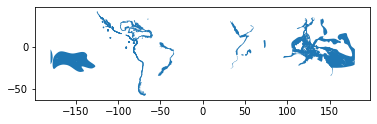

In [27]:
data.plot()

### Writing a Shapefile

Let’s select 50 first rows of the input data and write those into a new Shapefile by first selecting the data using index slicing and then write the selection into a Shapefile with the gpd.to_file() -function:

In [28]:
# Create an output path for the data
out_file_path = r"L2\DAMSELFISH_distributions_SELECTION.shp"

# Select first 50 rows, this a the numpy/pandas syntax to ``slice`` parts out a dataframe or array, from position 0 until (excluding) 50
selection = data[0:50]

# Write those rows into a new Shapefile (the default output file format is Shapefile)
selection.to_file(out_file_path)

### Geometries in Geopandas

Geopandas takes advantage of Shapely’s geometric objects. Geometries are typically stored in a column called geometry (or geom). This is a default column name for storing geometric information in geopandas.

In [29]:
data['geometry'].head()

0    POLYGON ((-115.64375 29.71392, -115.61585 29.6...
1    POLYGON ((-105.58995 21.89340, -105.56483 21.8...
2    POLYGON ((-111.15962 19.01536, -111.15948 18.9...
3    POLYGON ((-80.86500 -0.77894, -80.75930 -0.833...
4    POLYGON ((-67.33922 -55.67610, -67.33755 -55.6...
Name: geometry, dtype: geometry

Since spatial data is stored as Shapely objects, it is possible to use all of the functionalities of Shapely module that we practiced earlier.

In [30]:
selection = data[0:5]

In [31]:
for index, row in selection.iterrows():
    poly_area = row['geometry'].area
    print("Polygon area at index {0} is: {1:.3f}".format(index, poly_area))

Polygon area at index 0 is: 19.396
Polygon area at index 1 is: 6.146
Polygon area at index 2 is: 2.697
Polygon area at index 3 is: 87.461
Polygon area at index 4 is: 0.001


Hence, as you might guess from here, all the functionalities of Pandas are available directly in Geopandas without the need to call pandas separately because Geopandas is an extension for Pandas.

Let’s next create a new column into our GeoDataFrame where we calculate and store the areas individual polygons. Calculating the areas of polygons is really easy in geopandas by using GeoDataFrame.area attribute:

In [32]:
data['area'] = data.area

C:\Anaconda\envs\geopy2020\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [33]:
max_area = data['area'].max()
print(max_area)

1493.2009183643906


### Creating geometries into a GeoDataFrame

Since geopandas takes advantage of Shapely geometric objects it is possible to create a Shapefile from a scratch by passing Shapely’s geometric objects into the GeoDataFrame. This is useful as it makes it easy to convert e.g. a text file that contains coordinates into a Shapefile.

In [34]:
newdata = gpd.GeoDataFrame()
newdata

Empty GeoDataFrame
Columns: []
Index: []

The GeoDataFrame is empty since we haven’t placed any data inside.
Let’s create a new column called geometry that will contain our Shapely objects:

In [35]:
newdata['geometry'] = None
newdata

Empty GeoDataFrame
Columns: [geometry]
Index: []

Now we have a geometry column in our GeoDataFrame but we don’t have any data yet.

Let’s create a Shapely Polygon representing the Tartu Townhall square that we can insert to our GeoDataFrame:

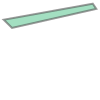

In [36]:
# Coordinates of the Tartu Townhall square in Decimal Degrees
coordinates = [(26.722117, 58.380184), (26.724853, 58.380676), (26.724961, 58.380518), (26.722372, 58.379933)]

# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)

# Let's see what we have
poly

In [37]:
# Insert the polygon into 'geometry' -column at index 0
newdata.loc[0, 'geometry'] = poly

# Let's see what we have now
newdata

geometry
0  POLYGON ((26.72212 58.38018, 26.72485 58.38068...

Now we have a GeoDataFrame with Polygon that we can export to a Shapefile.

Let’s add another column to our GeoDataFrame called Location with the text Tartu Townhall Square.

In [38]:
# Add a new column and insert data
newdata.loc[0, 'Location'] = 'Tartu Townhall Square'

# Let's check the data
newdata                    

geometry               Location
0  POLYGON ((26.72212 58.38018, 26.72485 58.38068...  Tartu Townhall Square

Before exporting the data it is useful to determine the coordinate reference system (projection) for the GeoDataFrame. GeoDataFrame has a property called .crs that (more about projection on next tutorial) shows the coordinate system of the data which is empty (None) in our case since we are creating the data from the scratch:

Let’s add a crs for our GeoDataFrame. A Python module called fiona has a nice function called from_epsg() for passing coordinate system for the GeoDataFrame. Next we will use that and determine the projection to WGS84 (epsg code: 4326) It is also possible to use the dutch rijksdriehoekstelsel by using epsg 28992.

In [39]:
 # Import specific function 'from_epsg' from fiona module
from fiona.crs import from_epsg

 # Set the GeoDataFrame's coordinate system to WGS84
newdata.crs = from_epsg(4326)

 # Let's see how the crs definition looks like
newdata.crs

C:\Anaconda\envs\geopy2020\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Geographic 2D CRS: +init=epsg:4326 +no_defs +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

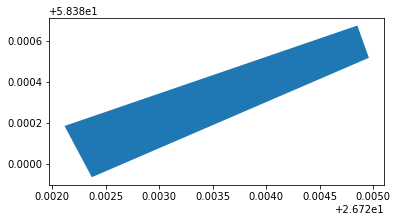

In [40]:
newdata.plot()

Finally, we can export the data using GeoDataFrames .to_file() -function. The function works similarly as numpy or pandas, but here we only need to provide the output path for the Shapefile:

In [41]:
# Determine the output path for the Shapefile
out_file = "raekoja_plats.shp"

# Write the data into that Shapefile
newdata.to_file(out_file)

### Practical example: Save multiple Shapefiles

One really useful function that can be used in Pandas/Geopandas is .groupby(). With the Group by function we can group data based on values on selected column(s).

Let’s group individual fish species in DAMSELFISH_distribution.shp and export to individual Shapefiles.

In [42]:
# Group the data by column 'BINOMIAL'
grouped = data.groupby('BINOMIAL')

# Let's see what we got
grouped

In [43]:
# Iterate over the group object
for key, values in grouped:
    individual_fish = values
    print(key)

Abudefduf concolor
Abudefduf declivifrons
Abudefduf troschelii
Amphiprion sandaracinos
Azurina eupalama
Azurina hirundo
Chromis alpha
Chromis alta
Chromis atrilobata
Chromis crusma
Chromis cyanea
Chromis flavicauda
Chromis intercrusma
Chromis limbaughi
Chromis pembae
Chromis punctipinnis
Chrysiptera flavipinnis
Hypsypops rubicundus
Microspathodon bairdii
Microspathodon dorsalis
Nexilosus latifrons
Stegastes acapulcoensis
Stegastes arcifrons
Stegastes baldwini
Stegastes beebei
Stegastes flavilatus
Stegastes leucorus
Stegastes rectifraenum
Stegastes redemptus
Teixeirichthys jordani


In [44]:
individual_fish.head()

ID_NO                BINOMIAL  ORIGIN COMPILER  YEAR  \
27  154915.0  Teixeirichthys jordani       1     None  2012   
28  154915.0  Teixeirichthys jordani       1     None  2012   
29  154915.0  Teixeirichthys jordani       1     None  2012   
30  154915.0  Teixeirichthys jordani       1     None  2012   
31  154915.0  Teixeirichthys jordani       1     None  2012   

                                             CITATION SOURCE DIST_COMM ISLAND  \
27  Red List Index (Sampled Approach), Zoological ...   None      None   None   
28  Red List Index (Sampled Approach), Zoological ...   None      None   None   
29  Red List Index (Sampled Approach), Zoological ...   None      None   None   
30  Red List Index (Sampled Approach), Zoological ...   None      None   None   
31  Red List Index (Sampled Approach), Zoological ...   None      None   None   

   SUBSPECIES  ... KINGDOM_NA PHYLUM_NAM      CLASS_NAME   ORDER_NAME  \
27       None  ...   ANIMALIA   CHORDATA  ACTINOPTERYGII  PERCIFORMES   
28       None  ...   ANIMALIA   CHORDATA  ACTINOPTERYGII  PERCIFORMES   
29       None  ...   ANIMALIA   CHORDATA  ACTINOPTERYGII  PERCIFORMES   
30       None  ...   ANIMALIA   CHORDATA  ACTINOPTERYGII  PERCIFORMES   
31       None  ...   ANIMALIA   CHORDATA  ACTINOPTERYGII  PERCIFORMES   

       FAMILY_NAM      GENUS_NAME SPECIES_NA CATEGORY  \
27  POMACENTRIDAE  Teixeirichthys    jordani       LC   
28  POMACENTRIDAE  Teixeirichthys    jordani       LC   
29  POMACENTRIDAE  Teixeirichthys    jordani       LC   
30  POMACENTRIDAE  Teixeirichthys    jordani       LC   
31  POMACENTRIDAE  Teixeirichthys    jordani       LC   

                                             geometry       area  
27  POLYGON ((121.63003 33.04249, 121.63219 33.042...  38.671198  
28  POLYGON ((32.56219 29.97489, 32.56497 29.96967...  37.445735  
29  POLYGON ((130.90521 34.02498, 130.90710 34.022...  16.939460  
30  POLYGON ((56.32233 -3.70727, 56.32294 -3.70872...  10.126967  
31  POLYGON ((40.64476 -10.85502, 40.64600 -10.855...   7.760303  

[5 rows x 25 columns]

From here we can see that an individual_fish variable now contains all the rows that belongs to a fish called Teixeirichthys jordani. Notice that the index numbers refer to the row numbers in the original data -GeoDataFrame.

As can be seen from the example above, each set of data are now grouped into separate GeoDataFrames that we can export into Shapefiles using the variable key for creating the output filepath names. Here we use a specific string formatting method to produce the output filename using the .format() (read more here (we use the new style with Python 3)). Let’s now export those species into individual Shapefiles.

In [45]:
# Determine outputpath
result_folder = "results_fish"

# Create a new folder called 'Results' (if does not exist) to that folder using os.makedirs() function
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

# Iterate over the
for key, values in grouped:
    # Format the filename (replace spaces with underscores)
    updated_key = key.replace(" ", "_")
    out_name = updated_key + ".shp"

    # Print some information for the user
    print( "Processing: {}".format(out_name) )

    # Create an output path, we join two folder names together without using slash or back-slash -> avoiding operating system differences
    outpath = os.path.join(result_folder, out_name)

    # Export the data
    values.to_file(outpath)

Processing: Abudefduf_concolor.shp
Processing: Abudefduf_declivifrons.shp
Processing: Abudefduf_troschelii.shp
Processing: Amphiprion_sandaracinos.shp
Processing: Azurina_eupalama.shp
Processing: Azurina_hirundo.shp
Processing: Chromis_alpha.shp
Processing: Chromis_alta.shp
Processing: Chromis_atrilobata.shp
Processing: Chromis_crusma.shp
Processing: Chromis_cyanea.shp
Processing: Chromis_flavicauda.shp
Processing: Chromis_intercrusma.shp
Processing: Chromis_limbaughi.shp
Processing: Chromis_pembae.shp
Processing: Chromis_punctipinnis.shp
Processing: Chrysiptera_flavipinnis.shp
Processing: Hypsypops_rubicundus.shp
Processing: Microspathodon_bairdii.shp
Processing: Microspathodon_dorsalis.shp
Processing: Nexilosus_latifrons.shp
Processing: Stegastes_acapulcoensis.shp
Processing: Stegastes_arcifrons.shp
Processing: Stegastes_baldwini.shp
Processing: Stegastes_beebei.shp
Processing: Stegastes_flavilatus.shp
Processing: Stegastes_leucorus.shp
Processing: Stegastes_rectifraenum.shp
Processi

Now we have saved those individual fishes into separate Shapefiles and named the file according to the species name. These kind of grouping operations can be really handy when dealing with Shapefiles. Doing similar process manually would be really laborious and error-prone.

In [46]:
# Open one of these generated shape files
fp = "results_fish/chromis_cyanea.shp"
data = gpd.read_file(fp)
data.head()

ID_NO        BINOMIAL  ORIGIN COMPILER  YEAR  \
0  165910.0  Chromis cyanea       1     None  2012   
1  165910.0  Chromis cyanea       1     None  2012   
2  165910.0  Chromis cyanea       1     None  2012   
3  165910.0  Chromis cyanea       1     None  2012   
4  165910.0  Chromis cyanea       1     None  2012   

                                            CITATION SOURCE DIST_COMM ISLAND  \
0  International Union for Conservation of Nature...   None      None   None   
1  International Union for Conservation of Nature...   None      None   None   
2  International Union for Conservation of Nature...   None      None   None   
3  International Union for Conservation of Nature...   None      None   None   
4  International Union for Conservation of Nature...   None      None   None   

  SUBSPECIES  ... KINGDOM_NA PHYLUM_NAM      CLASS_NAME   ORDER_NAME  \
0       None  ...   ANIMALIA   CHORDATA  ACTINOPTERYGII  PERCIFORMES   
1       None  ...   ANIMALIA   CHORDATA  ACTINOPTERYGII  PERCIFORMES   
2       None  ...   ANIMALIA   CHORDATA  ACTINOPTERYGII  PERCIFORMES   
3       None  ...   ANIMALIA   CHORDATA  ACTINOPTERYGII  PERCIFORMES   
4       None  ...   ANIMALIA   CHORDATA  ACTINOPTERYGII  PERCIFORMES   

      FAMILY_NAM GENUS_NAME SPECIES_NA CATEGORY        area  \
0  POMACENTRIDAE    Chromis     cyanea       LC  249.457390   
1  POMACENTRIDAE    Chromis     cyanea       LC    0.333061   
2  POMACENTRIDAE    Chromis     cyanea       LC    0.064204   
3  POMACENTRIDAE    Chromis     cyanea       LC    0.036003   
4  POMACENTRIDAE    Chromis     cyanea       LC    0.015251   

                                            geometry  
0  POLYGON ((-97.73440 24.66879, -97.74233 24.671...  
1  POLYGON ((-80.32910 16.53119, -80.21791 16.374...  
2  POLYGON ((-80.03610 16.04694, -79.98029 16.019...  
3  POLYGON ((-80.26047 14.34937, -80.30001 14.299...  
4  POLYGON ((-79.43817 16.09802, -79.34295 16.144...  

[5 rows x 25 columns]

## Coordinate Reference Systems (CRS)

Coordinate reference systems (CRS) are important because the geometric shapes in a GeoDataFrame are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates related to places on the Earth.

As map projections of gis-layers are fairly often defined differently (i.e. they do not match), it is a common procedure to redefine the map projections to be identical in both layers.

### Geographic coordinate system (GCS)

A geographic coordinate system uses a ellipsoidal surface to define locations on the Earth. There are three parts to a geographic coordinate system:

- A datum - an ellipsoidal (spheroid) model of the Earth to use. Common datums include WGS84 (used in GPS).

- A prime meridian

- Angular unit of measure

Both latitude and longitude are typically represented in two ways:

- Degrees, Minutes, Seconds (DMS), for example, 58° 23′ 12′ ′N, 26° 43′ 21′ ′E

- Decimal Degrees (DD) used by computers and stored as float data type, for example, 58.38667 and 26.7225

### Projected coordinate system (PCS)

Projected coordinate systems define a flat 2D Cartesian surface. Unlike a geographic coordinate system, a projected coordinate system has constant lengths, angles, and areas across the two dimensions. A projected coordinate system is always based on a geographic coordinate system that references a specific datum.

Projected Coordinate Systems consist of:

- Geographic Coordinate System

- Projection Method

- Projection Parameters (standard points and lines, Latitude of Origin, Longitude of Origin, False Easting, False Northing etc)

- Linear units (meters, kilometers, miles etc)

### Defining and changing CRSs in Geopandas

Luckily, defining and changing CRSs is easy in Geopandas. In this tutorial we will see how to retrieve the coordinate reference system information from the data, and how to change it. We will re-project a data file from WGS84 (lat, lon coordinates) into a Lambert Azimuthal Equal Area projection which is the recommended projection for Europe by European Commission.

In [47]:
# Filepath to the Europe borders Shapefile
fp = "europe_borders/Europe_borders.shp"

# Read data
data = gpd.read_file(fp)

# CRS
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

So from this disctionary we can see that the data is something called epsg:4326. The EPSG number (“European Petroleum Survey Group”) is a code that tells about the coordinate system of the dataset. “EPSG Geodetic Parameter Dataset is a collection of definitions of coordinate reference systems and coordinate transformations which may be global, regional, national or local in application”. EPSG-number 4326 that we have here belongs to the WGS84 coordinate system (i.e. coordinates are in decimal degrees (lat, lon)).

You can find a lot of information about different available coordinate reference systems from:
- www.spatialreference.org

- www.epsg.io

- www.proj4.org

- www.mapref.org

Let’s also check the values in our geometry column.

In [48]:
data['geometry'].head()

0    MULTIPOLYGON (((19.50115 40.96230, 19.50563 40...
1    POLYGON ((1.43992 42.60649, 1.45041 42.60596, ...
2    POLYGON ((16.00000 48.77775, 16.00000 48.78252...
3    POLYGON ((5.00000 49.79374, 4.99724 49.79696, ...
4    POLYGON ((19.22947 43.53458, 19.22925 43.53597...
Name: geometry, dtype: geometry

Changing the CRS is really easy to do in Geopandas with .to_crs() -function. As an input for the function, you should define the epgs value of the target CRS that you want to use.

In [49]:
# Let's take a copy of our layer
data_proj = data.copy()

# Reproject the geometries by replacing the values with projected ones
data_proj = data_proj.to_crs(epsg=3035)

To really understand what is going on, it is good to explore our data visually. Hence, let’s compare the datasets by making maps out of them.

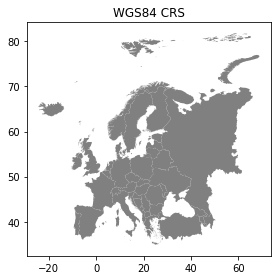

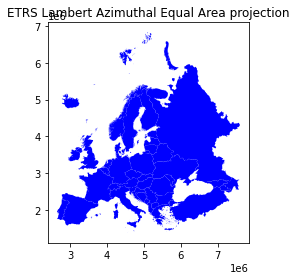

In [50]:
# Plot the WGS84
data.plot(facecolor='gray');

# Add title
plt.title("WGS84 CRS");

# Remove empty white space around the plot
plt.tight_layout()

# Plot the one with ETRS-LAEA projection
data_proj.plot(facecolor='blue');

# Add title
plt.title("ETRS Lambert Azimuthal Equal Area projection");

# Remove empty white space around the plot
plt.tight_layout()

Indeed, they look quite different and our re-projected one looks much better in Europe as the areas especially in the north are more realistic and not so stretched as in WGS84. (It is possible to pass more specific coordinate reference definition information as proj4 text)

In [51]:
# Ouput file path
out_fp = "Europe_borders_epsg3035.shp"

# Save to disk
data_proj.to_file(out_fp)

### Calculating distances

Let’s, continue working with our Europe_borders.shp file and find out the Euclidean distances from the centroids of the European countries to Tartu, Estonia. We will calculate the distance between Tartu and other European countries (centroids) using a metric projection (World Azimuthal Equidistant) that gives us the distance in meters.

Next we need to specify our CRS to metric system using World Azimuthal Equidistant -projection where distances are represented correctly from the center point. Let’s specify our target location to be the coordinates of Tartu (lon=26.7290 and lat=58.3780).

In [52]:
tartu_lon = 26.7290

tartu_lat = 58.3780

Next we need to specify a Proj4 string to reproject our data into World Azimuthal Equidistant in which we also want to center our projection to Tartu. We need to specify the +lat_0 and +lon_0 parameters in Proj4 string to do this.

In [53]:
proj4_txt = '+proj=aeqd +lat_0=58.3780 +lon_0=26.7290 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

Now we are ready to transform our Europe_borders.shp data into the desired projection. Let’s create a new copy of our GeoDataFrame called data_d (d for ‘distance’).

In [54]:
data_d = data.to_crs(proj4_txt)

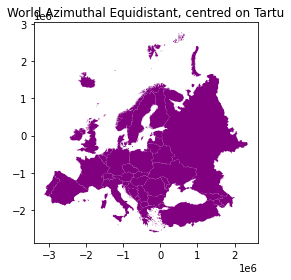

In [55]:
data_d.plot(facecolor='purple');

plt.title("World Azimuthal Equidistant, centred on Tartu");

plt.tight_layout();

Let’s continue our analysis by creating a Point object from Tartu and insert it into a GeoPandas GeoSeries. We also specify that the CRS of the GeoSeries is WGS84. You can do this by using crs parameter when creating the GeoSeries.

In [56]:
tartu = gpd.GeoSeries([Point(tartu_lon, tartu_lat)], crs=from_epsg(4326))

C:\Anaconda\envs\geopy2020\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [57]:
tartu = tartu.to_crs(proj4_txt)
tartu

0    POINT (0.00000 0.00000)
dtype: geometry

Next we need to calculate the centroids for all the Polygons of the European countries. This can be done easily in Geopandas by using the centroid attribute.

In [58]:
data_d['country_centroid'] = data_d.centroid
data_d.head(1)

NAME  ORGN_NAME                                           geometry  \
0  Albania  Shqipëria  MULTIPOLYGON (((-616930.849 -1905901.378, -616...   

                   country_centroid  
0  POINT (-566125.440 -1891201.934)

Now we can calculate the distances between the centroids and Tartu. We saw an example in an earlier lesson/exercise where we used apply() function for doing the loop instead of using the iterrows() function.

In (Geo)Pandas, the apply() function takes advantage of numpy when looping, and is hence much faster which can give a lot of speed benefit when you have many rows to iterate over. Here, we will see how we can use that to calculate the distance between the centroids and Tartu. We will create our own function to do this calculation.

In [59]:
def calculateDistance(row, dest_geom, src_col='geometry'):
    """
    Calculates the distance between a single Shapely Point geometry and a GeoDataFrame with Point geometries.

    Parameters
    ----------
    dest_geom : shapely.Point
        A single Shapely Point geometry to which the distances will be calculated to.
    src_col : str
        A name of the column that has the Shapely Point objects from where the distances will be calculated from.
    """
    # Calculate the distances
    dist = row[src_col].distance(dest_geom)
    # Tranform into kilometers
    dist_km = dist/1000
    # return the distance value
    return dist_km

The parameter row is used to pass the data from each row of our GeoDataFrame into our function and then the other paramaters are used for passing other necessary information for using our function.

Before using our function and calculating the distances between Tartu and centroids, we need to get the Shapely point geometry from the re-projected Tartu center point. We can use the get() function to retrieve a value from specific index (here index 0).

In [60]:
tartu_geom = tartu.get(0)

Now we are ready to use our function with apply() function. When using the function, it is important to specify that the axis=1. This specifies that the calculations should be done row by row (instead of column-wise).

In [61]:
data_d['dist_to_tartu'] = data_d.apply(calculateDistance, dest_geom=tartu_geom, src_col='country_centroid', axis=1)
data_d.head()

NAME            ORGN_NAME  \
0             Albania            Shqipëria   
1             Andorra              Andorra   
2             Austria           Österreich   
3             Belgium    België / Belgique   
4  Bosnia Herzegovina  Bosna i Hercegovina   

                                            geometry  \
0  MULTIPOLYGON (((-616930.849 -1905901.378, -616...   
1  POLYGON ((-2059909.806 -1383253.286, -2059109....   
2  POLYGON ((-789218.354 -1007540.792, -789139.78...   
3  POLYGON ((-1545487.015 -710685.915, -1545569.4...   
4  POLYGON ((-611931.236 -1618946.307, -611934.02...   

                    country_centroid  dist_to_tartu  
0   POINT (-566125.440 -1891201.934)    1974.118225  
1  POINT (-2051296.405 -1393144.787)    2479.651052  
2   POINT (-948755.523 -1114052.808)    1463.301302  
3   POINT (-1539443.737 -612758.131)    1656.912655  
4   POINT (-720901.335 -1534770.531)    1695.647168

In [62]:
max_dist = data_d['dist_to_tartu'].max()
print(f'max distance: {max_dist}')

max distance: 3403.982605055517


### Exercise 1 - Geospatial Crime Data

This is an independent exercise for you to practice working with Python, DataFrames and geometry data. 

Download the following CSV file: https://opendata.smit.ee/ppa/csv/avalik_3.csv and save it into your working folder. <br>

The data contains anonymised records of crimes, felonies and other offenses against the law (Estonia). The data is binned into squares of either 500mx500m or 1000mx1000m. However, whenever we work with datasets we can expect issues and errors with the data and have to be able to get the valuable information out.

#### Problem 1: Parse CSV file to get useful columns

The main problem is that a) all fields are text/string fields and can’t be acted upon immediately. Usually we need numerical data for analytical and geographical purposes.

In [63]:
df_exercise1 = pd.read_table("exercise1/avalik_3.csv").apply(lambda col: col.str.strip())
df_exercise1.head(4)

JuhtumId     ToimKpv ToimKell ToimNadalapaev  \
0  ec4cc3fc-1635-18d5-8326-a9a756483dba  2016-12-31    23:30        Laupäev   
1  ec4cc366-1635-18d5-8326-a9a756483dba  2016-12-31    18:00        Laupäev   
2  4297ad30-1636-18d5-8326-a9a756483dba  2016-12-31    18:00        Laupäev   
3  ec4cca46-1635-18d5-8326-a9a756483dba  2016-12-31    18:00        Laupäev   

               SyndmusLiik SyndmusTaiendavStatLiik             Seadus  \
0                   VARGUS              MUU_VARGUS  Karistusseadustik   
1                VANDALISM                     NaN  Karistusseadustik   
2  AVALIKU_KORRA_RIKKUMINE                     NaN  Karistusseadustik   
3  AVALIKU_KORRA_RIKKUMINE                     NaN  Karistusseadustik   

  Paragrahv                                      ParagrahvTais   Loige  \
0    § 199.                                      § 199. Vargus  lg. 1.   
1    § 218.  § 218. Varavastane süütegu väheväärtusliku asj...  lg. 1.   
2    § 262.                     § 262. Avaliku korra rikkumine  lg. 1.   
3    § 218.  § 218. Varavastane süütegu väheväärtusliku asj...  lg. 1.   

  Kahjusumma                         KohtLiik MaakondNimetus ValdLinnNimetus  \
0      0-499            AVALIK_KOHT,SOOGIKOHT  Harju maakond         Tallinn   
1        NaN         AVALIK_KOHT,TANAV_VALJAK  Harju maakond         Tallinn   
2        NaN                    HOTELL_MOTELL  Harju maakond         Tallinn   
3        NaN  AVALIK_KOHT,OUEALA_LAHTINE_HOOV  Harju maakond         Tallinn   

          KohtNimetus           Lest_X         Lest_Y SyyteoLiik  
0  Kesklinna linnaosa  6588500-6588999  542000-542499         KT  
1   Mustamäe linnaosa  6585000-6585499  538500-538999         VT  
2  Kesklinna linnaosa  6588500-6588999  543000-543499         VT  
3  Kesklinna linnaosa  6588500-6588999  543500-543999         VT

There are many interesting columns to analyse, like date and time of day of the offense, municipality, region or city, specific information about the type of offense, the damage caused and coordinate pairs. We will focus for now on the coordinate pairs Lest_X and Lest_Y as well as the damage caused Kahjusumma. These fields are text/strings, and contain usually two numbers, linked with a dash/minus, e.g. ‘6589000-6589499’ or ‘0-499’. 

Now these variables are technically still text/string objects. In order to extract and convert the number, which is maintained as a text object currently, we can try to cast into a numerical datatypes.

If we take a whole Pandas DataFrame column we can use the Pandas to_numeric function.

If you’d like to handle that on a per-element-level, you could do the cast/conversion in your function, using Python’s built-in cast functions int() or float()

Sometimes the data is not in a form or value that can be cast/converted in to numbers. In this case will get an Error, a so called Exception. In Python you can easily ask for forgiveness using a try: / except: block

Ideally, you will define some functions, and apply them one by one to create additional columns where you eventually hold the numerical values.

#### Problem 1: My Solution

In [64]:
def Exercise1(row, src_col='Lest_X'):
    try:
        # make a list by splitting, map values to integers and make a list of mapping variable
        x = row[src_col].split('-')
        x2 = map(int, x)
        li = list(x2)
        return li
    except:
        pass

In [65]:
df_exercise1['Lest_X_cleaned'] = df_exercise1.apply(Exercise1, src_col='Lest_X', axis=1)
df_exercise1['Lest_Y_cleaned'] = df_exercise1.apply(Exercise1, src_col='Lest_Y', axis=1)
df_exercise1.head()

JuhtumId     ToimKpv ToimKell ToimNadalapaev  \
0  ec4cc3fc-1635-18d5-8326-a9a756483dba  2016-12-31    23:30        Laupäev   
1  ec4cc366-1635-18d5-8326-a9a756483dba  2016-12-31    18:00        Laupäev   
2  4297ad30-1636-18d5-8326-a9a756483dba  2016-12-31    18:00        Laupäev   
3  ec4cca46-1635-18d5-8326-a9a756483dba  2016-12-31    18:00        Laupäev   
4  ec4cc32a-1635-18d5-8326-a9a756483dba  2016-12-31    16:38        Laupäev   

               SyndmusLiik SyndmusTaiendavStatLiik             Seadus  \
0                   VARGUS              MUU_VARGUS  Karistusseadustik   
1                VANDALISM                     NaN  Karistusseadustik   
2  AVALIKU_KORRA_RIKKUMINE                     NaN  Karistusseadustik   
3  AVALIKU_KORRA_RIKKUMINE                     NaN  Karistusseadustik   
4               PISIVARGUS                     NaN  Karistusseadustik   

  Paragrahv                                      ParagrahvTais   Loige  \
0    § 199.                                      § 199. Vargus  lg. 1.   
1    § 218.  § 218. Varavastane süütegu väheväärtusliku asj...  lg. 1.   
2    § 262.                     § 262. Avaliku korra rikkumine  lg. 1.   
3    § 218.  § 218. Varavastane süütegu väheväärtusliku asj...  lg. 1.   
4    § 218.  § 218. Varavastane süütegu väheväärtusliku asj...  lg. 1.   

  Kahjusumma                         KohtLiik MaakondNimetus ValdLinnNimetus  \
0      0-499            AVALIK_KOHT,SOOGIKOHT  Harju maakond         Tallinn   
1        NaN         AVALIK_KOHT,TANAV_VALJAK  Harju maakond         Tallinn   
2        NaN                    HOTELL_MOTELL  Harju maakond         Tallinn   
3        NaN  AVALIK_KOHT,OUEALA_LAHTINE_HOOV  Harju maakond         Tallinn   
4      0-499              AVALIK_KOHT,KAUPLUS  Harju maakond         Tallinn   

          KohtNimetus           Lest_X         Lest_Y SyyteoLiik  \
0  Kesklinna linnaosa  6588500-6588999  542000-542499         KT   
1   Mustamäe linnaosa  6585000-6585499  538500-538999         VT   
2  Kesklinna linnaosa  6588500-6588999  543000-543499         VT   
3  Kesklinna linnaosa  6588500-6588999  543500-543999         VT   
4  Haabersti linnaosa  6587500-6587999  536000-536499         VT   

       Lest_X_cleaned    Lest_Y_cleaned  
0  [6588500, 6588999]  [542000, 542499]  
1  [6585000, 6585499]  [538500, 538999]  
2  [6588500, 6588999]  [543000, 543499]  
3  [6588500, 6588999]  [543500, 543999]  
4  [6587500, 6587999]  [536000, 536499]

#### Problem 2: Polygons to map

Now you have the minimum and maximum values for X-coordinates, for Y-coordinates and for the damage values.

For the geographic coordinates, you need to build the polygons.

As there are meant as squares and are only given as bounding box values, we can immediately use Shapely’s box function.

#### Problem 2: My Solution

In [66]:
# use shapely box (shapely.geometry.box(minx, miny, maxx, maxy, ccw=True))
# makes a rectangular polygon from the provided bounding box values, with counter-clockwise order by default.
def Exercise2(row, src_colx='Lest_X_cleaned', src_coly='Lest_Y_cleaned'):
    try:
        minx = row[src_colx][0]
        miny = row[src_coly][0]
        maxx = row[src_colx][1]
        maxy = row[src_coly][1]
        # had to switch y and x to make the map look normal, unlike the documentation.
        b = box(miny, minx, maxy, maxx)
        return b
    except:
        pass

In [67]:
df_exercise1['geometry'] = df_exercise1.apply(Exercise2, src_colx='Lest_X_cleaned', src_coly='Lest_Y_cleaned', axis=1)
df_exercise1.head()

JuhtumId     ToimKpv ToimKell ToimNadalapaev  \
0  ec4cc3fc-1635-18d5-8326-a9a756483dba  2016-12-31    23:30        Laupäev   
1  ec4cc366-1635-18d5-8326-a9a756483dba  2016-12-31    18:00        Laupäev   
2  4297ad30-1636-18d5-8326-a9a756483dba  2016-12-31    18:00        Laupäev   
3  ec4cca46-1635-18d5-8326-a9a756483dba  2016-12-31    18:00        Laupäev   
4  ec4cc32a-1635-18d5-8326-a9a756483dba  2016-12-31    16:38        Laupäev   

               SyndmusLiik SyndmusTaiendavStatLiik             Seadus  \
0                   VARGUS              MUU_VARGUS  Karistusseadustik   
1                VANDALISM                     NaN  Karistusseadustik   
2  AVALIKU_KORRA_RIKKUMINE                     NaN  Karistusseadustik   
3  AVALIKU_KORRA_RIKKUMINE                     NaN  Karistusseadustik   
4               PISIVARGUS                     NaN  Karistusseadustik   

  Paragrahv                                      ParagrahvTais   Loige  ...  \
0    § 199.                                      § 199. Vargus  lg. 1.  ...   
1    § 218.  § 218. Varavastane süütegu väheväärtusliku asj...  lg. 1.  ...   
2    § 262.                     § 262. Avaliku korra rikkumine  lg. 1.  ...   
3    § 218.  § 218. Varavastane süütegu väheväärtusliku asj...  lg. 1.  ...   
4    § 218.  § 218. Varavastane süütegu väheväärtusliku asj...  lg. 1.  ...   

                          KohtLiik MaakondNimetus ValdLinnNimetus  \
0            AVALIK_KOHT,SOOGIKOHT  Harju maakond         Tallinn   
1         AVALIK_KOHT,TANAV_VALJAK  Harju maakond         Tallinn   
2                    HOTELL_MOTELL  Harju maakond         Tallinn   
3  AVALIK_KOHT,OUEALA_LAHTINE_HOOV  Harju maakond         Tallinn   
4              AVALIK_KOHT,KAUPLUS  Harju maakond         Tallinn   

          KohtNimetus           Lest_X         Lest_Y SyyteoLiik  \
0  Kesklinna linnaosa  6588500-6588999  542000-542499         KT   
1   Mustamäe linnaosa  6585000-6585499  538500-538999         VT   
2  Kesklinna linnaosa  6588500-6588999  543000-543499         VT   
3  Kesklinna linnaosa  6588500-6588999  543500-543999         VT   
4  Haabersti linnaosa  6587500-6587999  536000-536499         VT   

       Lest_X_cleaned    Lest_Y_cleaned  \
0  [6588500, 6588999]  [542000, 542499]   
1  [6585000, 6585499]  [538500, 538999]   
2  [6588500, 6588999]  [543000, 543499]   
3  [6588500, 6588999]  [543500, 543999]   
4  [6587500, 6587999]  [536000, 536499]   

                                            geometry  
0  POLYGON ((542499 6588500, 542499 6588999, 5420...  
1  POLYGON ((538999 6585000, 538999 6585499, 5385...  
2  POLYGON ((543499 6588500, 543499 6588999, 5430...  
3  POLYGON ((543999 6588500, 543999 6588999, 5435...  
4  POLYGON ((536499 6587500, 536499 6587999, 5360...  

[5 rows x 21 columns]

Then you can create a proper GeoDataFrame. The coordinates were provided in the Estonian National Grid system, EPSG:3301.

In [68]:
# Pandas to geopandas dataframe
gdf_exercise1 = gpd.GeoDataFrame(
    df_exercise1, geometry=df_exercise1.geometry, crs=from_epsg(3301)
)

C:\Anaconda\envs\geopy2020\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [69]:
# As you can see, I now created a geopandas dataframe with the Estonian National Grid system
gdf_exercise1.crs

<Projected CRS: +init=epsg:3301 +no_defs +type=crs>
Name: Estonian Coordinate System of 1997
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Estonia
- bounds: (20.37, 57.52, 28.2, 60.0)
Coordinate Operation:
- name: Estonian National Grid
- method: Lambert Conic Conformal (2SP)
Datum: Estonia 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### Problem 3: Summarize damages per area

currently, you have more than 40000 records/polygons. However, as you might or might have not realized, there are many that have the same geometry, thus, offense reported in the same area.
Find a meaningful to summarize the average damages per square.

#### Problem 3: My Solution

In [70]:
# combine a string value of X and Y coördinates to be able to group by it.
gdf_exercise1['string_coordinates'] = gdf_exercise1['Lest_X'] + gdf_exercise1['Lest_Y']
gdf_exercise1.head(3)

JuhtumId     ToimKpv ToimKell ToimNadalapaev  \
0  ec4cc3fc-1635-18d5-8326-a9a756483dba  2016-12-31    23:30        Laupäev   
1  ec4cc366-1635-18d5-8326-a9a756483dba  2016-12-31    18:00        Laupäev   
2  4297ad30-1636-18d5-8326-a9a756483dba  2016-12-31    18:00        Laupäev   

               SyndmusLiik SyndmusTaiendavStatLiik             Seadus  \
0                   VARGUS              MUU_VARGUS  Karistusseadustik   
1                VANDALISM                     NaN  Karistusseadustik   
2  AVALIKU_KORRA_RIKKUMINE                     NaN  Karistusseadustik   

  Paragrahv                                      ParagrahvTais   Loige  ...  \
0    § 199.                                      § 199. Vargus  lg. 1.  ...   
1    § 218.  § 218. Varavastane süütegu väheväärtusliku asj...  lg. 1.  ...   
2    § 262.                     § 262. Avaliku korra rikkumine  lg. 1.  ...   

  MaakondNimetus ValdLinnNimetus         KohtNimetus           Lest_X  \
0  Harju maakond         Tallinn  Kesklinna linnaosa  6588500-6588999   
1  Harju maakond         Tallinn   Mustamäe linnaosa  6585000-6585499   
2  Harju maakond         Tallinn  Kesklinna linnaosa  6588500-6588999   

          Lest_Y SyyteoLiik      Lest_X_cleaned    Lest_Y_cleaned  \
0  542000-542499         KT  [6588500, 6588999]  [542000, 542499]   
1  538500-538999         VT  [6585000, 6585499]  [538500, 538999]   
2  543000-543499         VT  [6588500, 6588999]  [543000, 543499]   

                                            geometry  \
0  POLYGON ((542499.000 6588500.000, 542499.000 6...   
1  POLYGON ((538999.000 6585000.000, 538999.000 6...   
2  POLYGON ((543499.000 6588500.000, 543499.000 6...   

             string_coordinates  
0  6588500-6588999542000-542499  
1  6585000-6585499538500-538999  
2  6588500-6588999543000-543499  

[3 rows x 22 columns]

In [71]:
# use the geopandas dissolve function to group by the string coördinates and count the felonies in that area.
dissolved = gdf_exercise1[['geometry', 'string_coordinates','JuhtumId']]
dissolved = dissolved.dissolve(by='string_coordinates', aggfunc='count')
dissolved.head(5)

geometry  \
string_coordinates                                                                
6386000-6386999648000-648999  POLYGON ((648999.000 6386000.000, 648999.000 6...   
6387000-6387999650000-650999  POLYGON ((650999.000 6387000.000, 650999.000 6...   
6388000-6388999643000-643999  POLYGON ((643999.000 6388000.000, 643999.000 6...   
6388000-6388999644000-644999  POLYGON ((644999.000 6388999.000, 644999.000 6...   
6388000-6388999655000-655999  POLYGON ((655999.000 6388000.000, 655999.000 6...   

                              JuhtumId  
string_coordinates                      
6386000-6386999648000-648999         1  
6387000-6387999650000-650999         1  
6388000-6388999643000-643999         1  
6388000-6388999644000-644999         3  
6388000-6388999655000-655999         1

Now lets add a map of Estonia.
https://geoportaal.maaamet.ee/eng/Spatial-Data/Administrative-and-Settlement-Division-p312.html

In [72]:
# Open the file
fp = "exercise1/maakond_20220401.shp"
map_data = gpd.read_file(fp)
# The coordinate system is already correct
map_data.crs

<Projected CRS: EPSG:3301>
Name: Estonian Coordinate System of 1997
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Estonia
- bounds: (20.37, 57.52, 28.2, 60.0)
Coordinate Operation:
- name: Estonian National Grid
- method: Lambert Conic Conformal (2SP)
Datum: Estonia 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

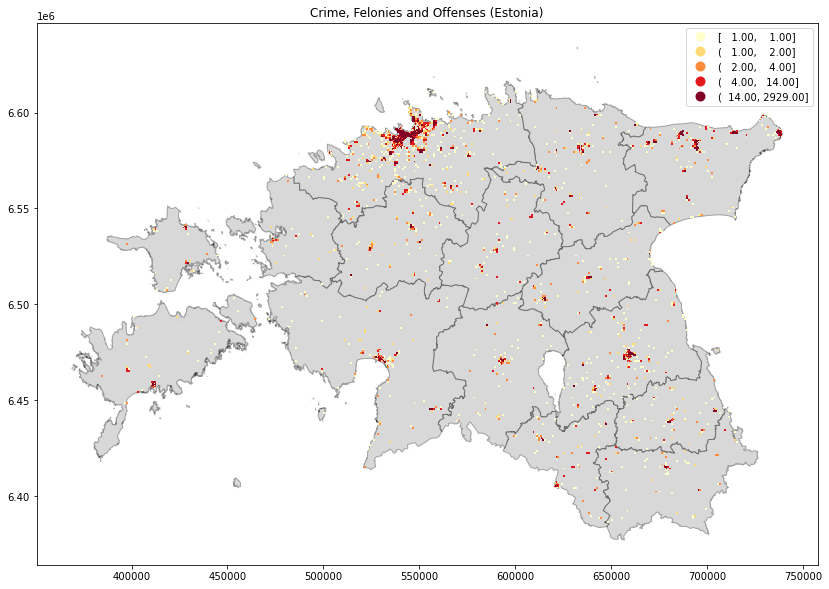

In [73]:
# plot the data
plt.rcParams['figure.figsize'] = [14, 14]
ax = map_data.plot(color='grey', alpha=0.3, edgecolor='black')
dissolved.plot(column = 'JuhtumId', scheme='quantiles', cmap='YlOrRd', ax=ax, legend=True)
plt.title("Crime, Felonies and Offenses (Estonia)")
plt.orientation='horizontal'

# Lesson 3

During this lesson we will learn a few really useful and commonly used GIS functionalities using Geopandas, namely:

- Conducting Point in Polygon queries

- Making Spatial joins

After this lessons’ lesson you should be able to:

- Conduct a Point in Polygon queries

- Read data from GeoJSON and GeoPackage files

- Make spatial and table joins between layers and lookup tables

## Point in Polygon & Intersect

Finding out if a certain point is located inside or outside of an area, or finding out if a line intersects with another line or polygon are fundamental geospatial operations that are often used e.g. to select data based on location.

### How to check if point is inside a polygon?

Computationally, detecting if a point is inside a polygon is a complicated matter. Luckily, we can use ready-made function for conducting the Point in Polygon query. We can take advantage of Shapely’s binary predicates that can evaluate the topolocical relationships between geographical objects, such as the PIP as we’re interested here.

There are basically two ways of conducting Point in Polygon queries in Shapely:

- using a function called .within() that checks if a point is within a polygon

- using a function called .contains() that checks if a polygon contains a point

In [74]:
# Create Point objects
p1 = Point(24.952242, 60.1696017)
p2 = Point(24.976567, 60.1612500)

# Create a Polygon
coords = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]
poly = Polygon(coords)

In [75]:
# Check if p1 is within the polygon using the within function
print(p1.within(poly))

# Check if p2 is within the polygon
p2.within(poly)

True


False

In [76]:
# Does polygon contain p1?
print(poly.contains(p1))

# Does polygon contain p2?
poly.contains(p2)

True


False

Thus, both ways of checking the spatial relationship results in the same way.

Which one should you use then? Well, it depends:

- if you have many points and just one polygon and you try to find out which one of them is inside the polygon:

- you need to iterate over the points and check one at a time if it is within() the polygon specified

- if you have many polygons and just one point and you want to find out which polygon contains the point

- you need to iterate over the polygons until you find a polygon that contains() the point specified (assuming there are no overlapping polygons)

### Intersect

Another typical geospatial operation is to see if a geometry intersect or touches another one. The difference between these two is that:

- if objects intersect, the boundary and interior of an object needs to intersect in any way with those of the other.

- If an object touches the other one, it is only necessary to have (at least) a single point of their boundaries in common but their interiors shoud NOT intersect.

In [77]:
# Create two lines
line_a = LineString([(0, 0), (1, 1)])
line_b = LineString([(1, 1), (0, 2)])

In [78]:
# See if intersects
line_a.intersects(line_b)

True

In [79]:
# See if touches
line_a.touches(line_b)

True

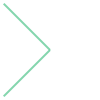

In [80]:
# Create a MultiLineString
multi_line = MultiLineString([line_a, line_b])
multi_line

### Point in Polygon using Geopandas

Next we will do a practical example where we check which of Estonian Category III protected species sightings from a prepared monitoring GeoPackage file, category_3_species_porijogi.gpkg, are located in the Idaoja sub-catchment of the Porijogi river, by cross-checking with the polygons from a GeoJSON-file . The Polygons are the modelled sub-catchments of the Porijogi river.

In [81]:
# protected species under class 3 monitoring sightings
species_fp = "L3/category_3_species_porijogi.gpkg"
species_data = gpd.read_file(species_fp, layer='category_3_species_porijogi', driver='GPKG')
species_data.head(3)

C:\Anaconda\envs\geopy2020\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


OBJECTID        LIIK             NIMI  EXT_SYST_I    KKR_KOOD PRIV_TYYP  \
0    148179  taimed III     soo-neiuvaip   652542557  KLO9320309    Avalik   
1    148180  taimed III     soo-neiuvaip  1989720139  KLO9320255    Avalik   
2    162026  loomad III  valge-toonekurg  -665748946  KLO9108356  Peidetud   

        STAATUS  IMPORT  LAADIMISKP                        geometry  
0  kontrollitud       0  2018-10-29  POINT (646978.483 6444887.321)  
1  kontrollitud       0  2018-10-29  POINT (646730.472 6459776.774)  
2  arhiveeritud       0  2019-09-26  POINT (653008.611 6467205.284)

In [82]:
polys_fp = "L3/porijogi_sub_catchments.geojson"
polys = gpd.read_file(polys_fp, driver='GeoJSON')
polys.head(3)

OBJECTID     NAME_1       AREA_1    Shape_Leng    Shape_Area  ID  \
0         8     Idaoja  3823.427995  35446.162219  3.823428e+07   1   
1         9  Keskjooks  5087.809731  42814.174755  5.087810e+07   2   
2        10      Peeda  5634.162684  47792.268153  5.634163e+07   3   

                                            geometry  
0  MULTIPOLYGON (((660834.858 6455555.914, 660851...  
1  MULTIPOLYGON (((666339.502 6455972.600, 666384...  
2  MULTIPOLYGON (((659914.002 6456514.131, 659817...

Nice, now we can see that we have the sub-diveded catchments for the Porijogi river. We are interested in the sub-catchment that is called Idaoja. Let’s select that one and see where it is located, and plot also the points on top of the map.

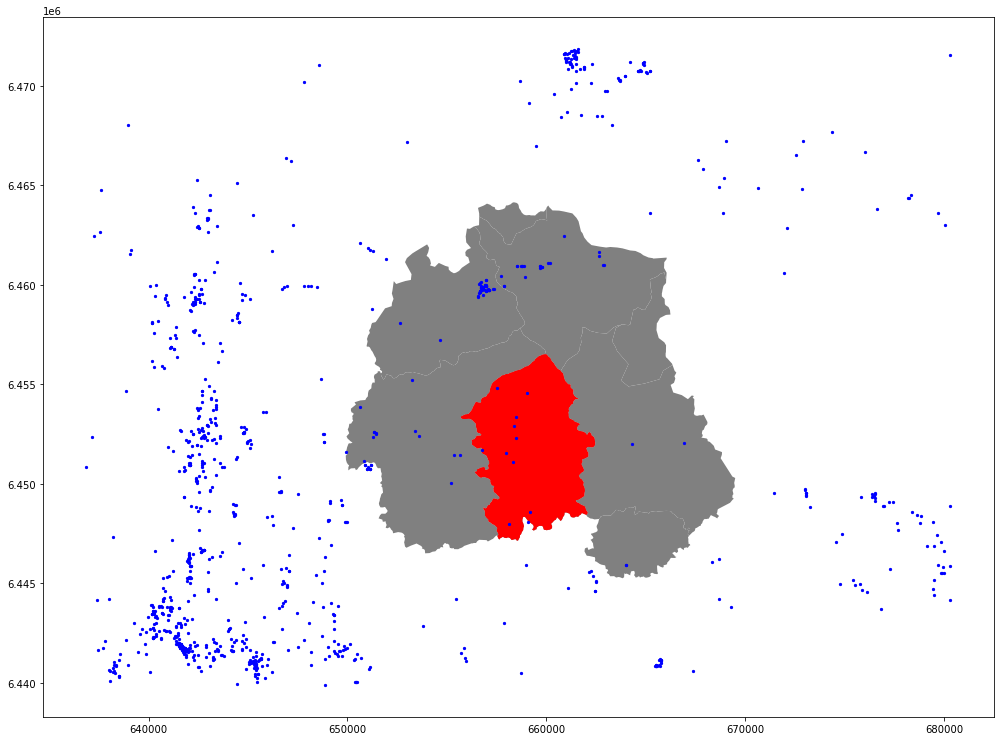

In [83]:
subcatch = polys.loc[polys['NAME_1']=='Idaoja']

fig, ax = plt.subplots()

polys.plot(ax=ax, facecolor='gray')

subcatch.plot(ax=ax, facecolor='red')

species_data.plot(ax=ax, color='blue', markersize=5)

plt.tight_layout()

Okey, so we can see that, indeed, certain points are within the selected red Polygon.

Let’s find out which one of them are located within the Polygon. Hence, we are conducting a Point in Polygon query.

Let’s first enable shapely.speedups which makes some of the spatial queries running faster!

In [84]:
import shapely.speedups
shapely.speedups.enable()

Let’s check which Points are within the subcatch Polygon. Notice, that here we check if the Points are within the geometry of the subcatch GeoDataFrame. Hence, we use the loc[0, 'geometry'] to parse the actual Polygon geometry object from the GeoDataFrame.

In [85]:
pip_mask = species_data['geometry'].within(subcatch.loc[0, 'geometry'])
display(pip_mask)

0       False
1       False
2       False
3       False
4       False
        ...  
1032    False
1033    False
1034    False
1035    False
1036    False
Length: 1037, dtype: bool

As we can see, we now have an array of boolean values for each row, where the result is True if Point was inside the Polygon, and False if it was not.

We can now use this mask array to select the Points that are inside the Polygon. Selecting data with this kind of mask array (of boolean values) is easy by passing the array inside the loc indexing function of Pandas.

In [86]:
pip_data = species_data.loc[pip_mask]
pip_data.head(3)

OBJECTID        LIIK             NIMI   EXT_SYST_I    KKR_KOOD PRIV_TYYP  \
249    152958  taimed III    ohakasoomukas  -1902179792  KLO9331094    Avalik   
674    145079  loomad III  valge-toonekurg  -1632330969  KLO9105497    Avalik   
691    145191  loomad III  valge-toonekurg   1355787943  KLO9105625    Avalik   

          STAATUS  IMPORT  LAADIMISKP                        geometry  
249  kontrollitud       0  2018-10-29  POINT (657531.007 6454827.405)  
674  kontrollitud       0  2018-10-29  POINT (657952.380 6451525.770)  
691  kontrollitud       0  2018-10-29  POINT (659189.190 6448592.205)

Let’s finally confirm that our Point in Polygon query worked as it should by plotting the data.

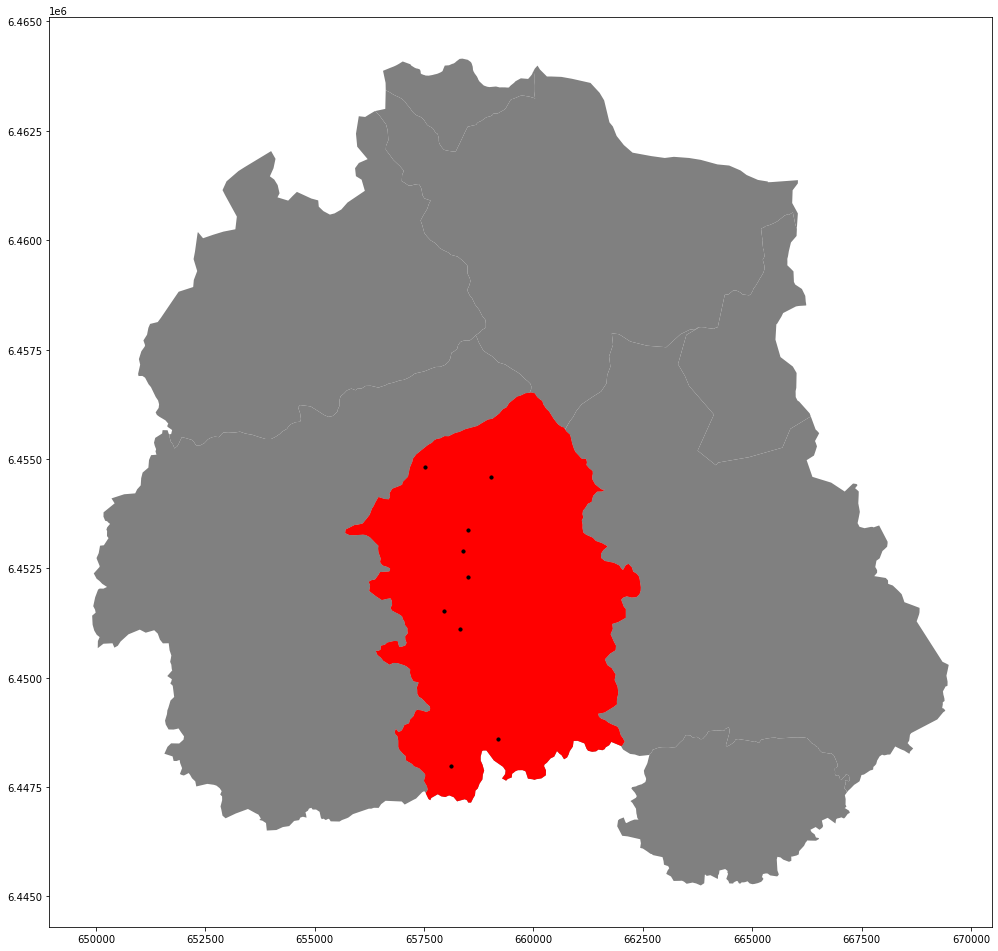

In [87]:
subcatch = polys.loc[polys['NAME_1']=='Idaoja']

fig, ax = plt.subplots()

polys.plot(ax=ax, facecolor='gray')

subcatch.plot(ax=ax, facecolor='red')

pip_data.plot(ax=ax, color='black', markersize=10)

plt.tight_layout()

## Spatial Join

A Spatial join is yet another classic GIS problem. Getting attributes from one layer and transferring them into another layer based on their spatial relationship is something you most likely need to do on a regular basis.

The previous materials focused on learning how to perform a Point in Polygon query. We could now apply those techniques and create our own function to perform a spatial join between two layers based on their spatial relationship. We could for example join the attributes of a polygon layer into a point layer where each point would get the attributes of a polygon that contains the point.

Luckily, spatial joins (gpd.sjoin() -function) is already implemented in Geopandas, thus we do not need to create it ourselves. There are three possible types of join that can be applied in spatial join that are determined with op -parameter:

- "intersects"

- "within"

- "contains"

Let’s perform a spatial join between the species monitoring data GeoPackage file, category_3_species_porijogi.gpkg and a Polygon layer that is extracted Corine Landuse Cover for the Porijogi region.

### Download and clean the data

In [88]:
# Filepath
fp = "L3/porijogi_corine_landuse.shp"

# Read the data
lulc = gpd.read_file(fp)

lulc.head(3)

code_12          id remark    area_ha    shape_area  clc_int Landuse  \
0     112  EU-2024407   None  67.055321  670553.20630      112    URML   
1     112  EU-2024418   None  36.452500  364525.00295      112    URML   
2     112  EU-2024426   None  33.525145  335251.45070      112    URML   

                                            geometry  
0  POLYGON ((658854.791 6458244.203, 658826.936 6...  
1  POLYGON ((663553.865 6459840.806, 663570.622 6...  
2  POLYGON ((659006.349 6463680.667, 659031.241 6...

Okey so we have multiple columns in the dataset but the most important one here is the column clc_int (corine landuse code) that tells the type of landuse cover under that polygon. Download the codes lookup table

In [89]:
codes = pd.read_csv('L3/corine_landuse_codes.csv', sep=';')
codes.head(3)

CLC_CODE               LABEL1                                      LABEL2  \
0       111  Artificial surfaces                                Urban fabric   
1       112  Artificial surfaces                                Urban fabric   
2       121  Artificial surfaces  Industrial, commercial and transport units   

                           LABEL3          RGB  
0         Continuous urban fabric  230-000-077  
1      Discontinuous urban fabric  255-000-000  
2  Industrial or commercial units  204-077-242

This table contains a field CLC_CODE which we use to connect the correct mapping to our landuse cover GeoDataframe, which has a field clc_int. We will now merge the lookup table codes (a Pandas dataframe) into our lulc GeoDataframe, based on the identifiers in the mentioned fields

In [90]:
lulc = lulc.merge(codes, left_on='clc_int', right_on='CLC_CODE')

In [91]:
# Let’s also get rid of all unnecessary columns by selecting only columns that we need 
# i.e. Landuse, LABEL2 and geometry
selected_cols = ['Landuse', 'LABEL2','geometry']
lulc = lulc[selected_cols]
lulc.head(3)

Landuse        LABEL2                                           geometry
0    URML  Urban fabric  POLYGON ((658854.791 6458244.203, 658826.936 6...
1    URML  Urban fabric  POLYGON ((663553.865 6459840.806, 663570.622 6...
2    URML  Urban fabric  POLYGON ((659006.349 6463680.667, 659031.241 6...

### Join the layers

Now we are ready to perform the spatial join between the two layers that we have. The aim here is to get information about how many species sightings (of which species) happened in which landuse types? . Thus, we want to join attributes from the landuse layer we just modified into the already used and prepared monitoring GeoPackage file, category_3_species_porijogi.gpkg.

In [92]:
species_fp = "L3/category_3_species_porijogi.gpkg"
species = gpd.read_file(species_fp, layer='category_3_species_porijogi', driver='GPKG')

C:\Anaconda\envs\geopy2020\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [93]:
species.head(3)

OBJECTID        LIIK             NIMI  EXT_SYST_I    KKR_KOOD PRIV_TYYP  \
0    148179  taimed III     soo-neiuvaip   652542557  KLO9320309    Avalik   
1    148180  taimed III     soo-neiuvaip  1989720139  KLO9320255    Avalik   
2    162026  loomad III  valge-toonekurg  -665748946  KLO9108356  Peidetud   

        STAATUS  IMPORT  LAADIMISKP                        geometry  
0  kontrollitud       0  2018-10-29  POINT (646978.483 6444887.321)  
1  kontrollitud       0  2018-10-29  POINT (646730.472 6459776.774)  
2  arhiveeritud       0  2019-09-26  POINT (653008.611 6467205.284)

In [94]:
# check if crs matches
lulc.crs == species.crs

True

They are identical. Thus, we can be sure that when doing spatial queries between layers the locations match and we get the right results e.g. from the spatial join that we are conducting here.

Let’s now join the attributes from lulc (2) GeoDataFrame into species GeoDataFrame (1) by using gpd.sjoin() -function

In [95]:
join = gpd.sjoin(species, lulc, how="inner", op="within")

# Let's check the result
join.head(3)

OBJECTID        LIIK               NIMI   EXT_SYST_I    KKR_KOOD  \
126    144115  taimed III  läikiv kurdsirbik  -1324418359  KLO9400024   
132    144202  taimed III    siberi võhumõõk   1344032932  KLO9312850   
157    151696  taimed III     balti sõrmkäpp   -376320786  KLO9317690   

    PRIV_TYYP       STAATUS  IMPORT  LAADIMISKP  \
126    Avalik  kontrollitud       0  2018-10-29   
132    Avalik  kontrollitud       0  2018-10-29   
157    Avalik  kontrollitud       0  2018-10-29   

                           geometry  index_right Landuse  \
126  POINT (652641.854 6458099.088)          224    RNGB   
132  POINT (660367.911 6469599.134)          143    FRSD   
157  POINT (656609.812 6459582.666)          201    FRST   

                                              LABEL2  
126  Scrub and/or herbaceous vegetation associations  
132                                          Forests  
157                                          Forests

In [96]:
# Output path
outfp = "L3/landuse_per_species.shp"

# Save to disk
join.to_file(outfp)

Do the results make sense? Let’s evaluate this a bit by grouping and querying the resulting join for largest landuse type and species types combinations:

In [97]:
join['LABEL2'].value_counts()

Forests                                            52
Heterogeneous agricultural areas                   22
Scrub and/or herbaceous vegetation associations    22
Pastures                                            4
Inland waters                                       2
Urban fabric                                        2
Arable land                                         2
Inland wetlands                                     1
Name: LABEL2, dtype: int64

In [98]:
# initialise empty list
data_list = []

for species_id, species_group in join.groupby('NIMI'):
    lulc_count = species_group['LABEL2'].value_counts()
    top = lulc_count.head(1)
    data_list.append({'species_id':species_id, 'all_sights': len(species_group), 'top_lulc': top.index[0], 'sights_in_top': top[0]}) 

# Creates DataFrame from now filled list wit hdata items.
top_sights = pd.DataFrame(data_list)

# Print the data
top_sights.sort_values(by=['all_sights','sights_in_top'], ascending=False).head(10)

species_id  all_sights  \
18         valge-toonekurg          20   
2           balti sõrmkäpp          20   
6   kahkjaspunane sõrmkäpp          17   
15            suur käopõll          16   
1             aas-karukell           6   
13            soo-neiuvaip           5   
21       vööthuul-sõrmkäpp           5   
4        harilik käoraamat           2   
12         siberi võhumõõk           2   
14            sulgjas õhik           2   

                                           top_lulc  sights_in_top  
18                 Heterogeneous agricultural areas             15  
2                                           Forests             12  
6                                           Forests             12  
15                                          Forests             14  
1                                           Forests              4  
13  Scrub and/or herbaceous vegetation associations              3  
21                                          Forests              3  
4   Scrub and/or herbaceous vegetation associations              1  
12                 Heterogeneous agricultural areas              1  
14  Scrub and/or herbaceous vegetation associations              1

# Lesson 4

During this lesson we will learn a few really useful and commonly used GIS functionalities using Geopandas and PySAL.

Learning goals
After this lesson’s lesson you should be able to:

- learn about different classification schemes

- reclassify data based on different criteria (custom or common classifiers).

- merge data, i.e. join spatial and non-spatial datasets together, based on some common identifier.

## Data reclassification

Reclassifying data based on specific criteria is a common task when doing GIS analysis. The purpose of this lesson is to see how we can reclassify values based on some criteria which can be whatever, but typical are related to a logical decision tree.

We will use Corine land cover layer from year 2012, and a Population Matrix data from Estonia to classify some features of them based on our own self-made classifier, or using a ready made classifiers that are commonly used e.g. when doing visualizations.

The target in this part of the lesson is to:

- classify the bogs into big and small bogs where

- a big bog is a bog that is larger than the average size of all bogs in our study region

- a small bog ^ vice versa

- use ready made classifiers from pysal -module to classify municipal into multiple classes.

### Data preparation

In [99]:
fp = "L4/corine_tartu.shp"
data = gpd.read_file(fp)
data.head(3)

code_12          ID Remark    Area_Ha   Shape_Leng     Shape_Area  \
0     111  EU-2024275   None  51.462132  4531.639281  514621.315450   
1     112  EU-2024328   None  25.389164   143.790405     153.109311   
2     112  EU-2024336   None  28.963212  2974.801106  289632.119850   

                                            geometry  
0  POLYGON Z ((5290566.200 4034511.450 0.000, 529...  
1  MULTIPOLYGON Z (((5259932.400 3993825.370 0.00...  
2  POLYGON Z ((5268691.710 3996582.900 0.000, 526...

We see that the Land Use in column “code_12” is numerical and we don’t know right now what that means. So we should at first join the “clc_legend” in order to know what the codes mean

In [100]:
fp_clc = "L4/corine_legend/clc_legend.csv"
data_legend = pd.read_csv(fp_clc, sep=';', encoding='latin1')
data_legend.head(3)

GRID_CODE  CLC_CODE                          LABEL3          RGB
0          1       111         Continuous urban fabric  230-000-077
1          2       112      Discontinuous urban fabric  255-000-000
2          3       121  Industrial or commercial units  204-077-242

we will receive an error telling us that the columns are of different data type and therefore can’t be used as join-index. So we have to add a column where have the codes in the same type. I am choosing to add a column on “data”, where we transform the String/Text based “code_12” into an integer number.

In [101]:
data['code_12'] = data['code_12'].astype('int', copy=True)

In [102]:
data.head(3)

code_12          ID Remark    Area_Ha   Shape_Leng     Shape_Area  \
0      111  EU-2024275   None  51.462132  4531.639281  514621.315450   
1      112  EU-2024328   None  25.389164   143.790405     153.109311   
2      112  EU-2024336   None  28.963212  2974.801106  289632.119850   

                                            geometry  
0  POLYGON Z ((5290566.200 4034511.450 0.000, 529...  
1  MULTIPOLYGON Z (((5259932.400 3993825.370 0.00...  
2  POLYGON Z ((5268691.710 3996582.900 0.000, 526...

Now we can merge/join the legend dateframe into our corine landuse dataframe

In [103]:
data = data.merge(data_legend, how='inner', left_on='code_12', right_on='CLC_CODE', suffixes=('', '_legend'))

In [104]:
selected_cols = ['ID','Remark','Shape_Area','CLC_CODE','LABEL3','RGB','geometry']
# Select data
data = data[selected_cols]
data.head(3)

ID Remark     Shape_Area  CLC_CODE                      LABEL3  \
0  EU-2024275   None  514621.315450       111     Continuous urban fabric   
1  EU-2024328   None     153.109311       112  Discontinuous urban fabric   
2  EU-2024336   None  289632.119850       112  Discontinuous urban fabric   

           RGB                                           geometry  
0  230-000-077  POLYGON Z ((5290566.200 4034511.450 0.000, 529...  
1  255-000-000  MULTIPOLYGON Z (((5259932.400 3993825.370 0.00...  
2  255-000-000  POLYGON Z ((5268691.710 3996582.900 0.000, 526...

Before we plot, let’s check the coordinate system.

In [105]:
data.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - LCC & LAEA
- bounds: (-35.58, 24.6, 44.83, 84.17)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Okey we can see that the units are in meters, but …

… geographers will realise that the Corine dataset is in the ETRS89 / LAEA Europe coordinate system, aka EPSG:3035. Because it is a European dataset it is in the recommended CRS for Europe-wide data. It is a single CRS for all of Europe and predominantly used for statistical mapping at all scales and other purposes where true area representation is required.

However, being in Estonia and only using an Estonian part of the data, we should consider reprojecting it into the Estonian national grid (aka Estonian Coordinate System of 1997 -> EPSG:3301) before we plot or calculate the area of our bogs.

In [106]:
data_proj = data.to_crs(epsg=3301)

# Calculate the area of bogs
data_proj['area'] = data_proj.area

# What do we have?
data_proj.head(3)

ID Remark     Shape_Area  CLC_CODE                      LABEL3  \
0  EU-2024275   None  514621.315450       111     Continuous urban fabric   
1  EU-2024328   None     153.109311       112  Discontinuous urban fabric   
2  EU-2024336   None  289632.119850       112  Discontinuous urban fabric   

           RGB                                           geometry  \
0  230-000-077  POLYGON Z ((659353.810 6474471.492 0.000, 6594...   
1  255-000-000  MULTIPOLYGON Z (((621023.813 6440589.993 0.000...   
2  255-000-000  POLYGON Z ((630182.366 6441591.987 0.000, 6301...   

            area  
0  514565.037797  
1     153.104211  
2  289621.547453

Let’s plot the data and use column ‘CLC_CODE’ as our color.

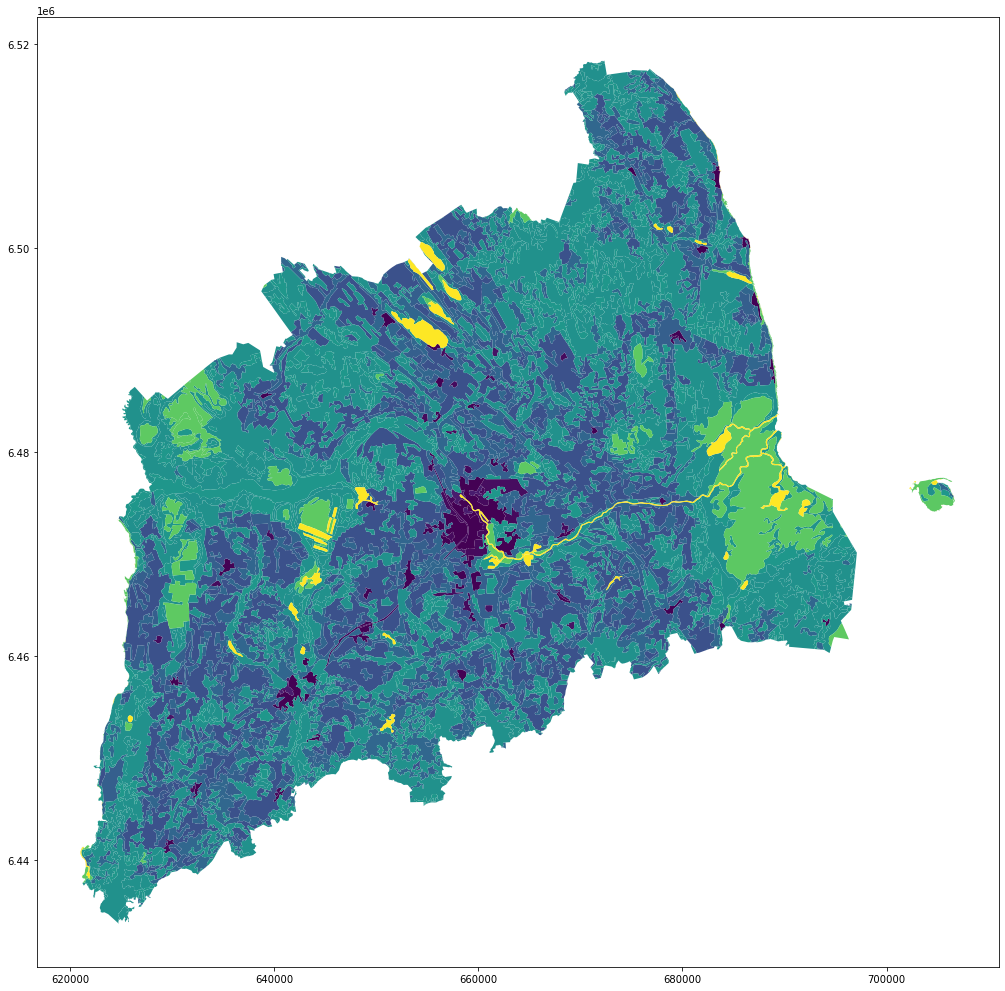

In [107]:
data_proj.plot(column='CLC_CODE', linewidth=0.05)

# Use tight layout and remove empty whitespace around our map
plt.tight_layout()

Okey we have different kind of land covers in our data. Let’s select only bogs from our data. Selecting specific rows from a DataFrame based on some value(s) is easy to do in Pandas / Geopandas using the indexer called .loc[]

In [108]:
# Find bog value
print(list(data_proj['LABEL3'].unique()))

['Continuous urban fabric', 'Discontinuous urban fabric', 'Industrial or commercial units', 'Road and rail networks and associated land', 'Airports', 'Mineral extraction sites', 'Construction sites', 'Green urban areas', 'Sport and leisure facilities', 'Non-irrigated arable land', 'Fruit trees and berry plantations', 'Pastures', 'Complex cultivation patterns', 'Land principally occupied by agriculture, with significant areas of natural vegetation', 'Broad-leaved forest', 'Coniferous forest', 'Mixed forest', 'Natural grasslands', 'Transitional woodland-shrub', 'Inland marshes', 'Peat bogs', 'Water courses', 'Water bodies']


In [109]:
bogs = data_proj.loc[data['LABEL3'] == 'Peat bogs']

bogs.head(3)

ID Remark    Shape_Area  CLC_CODE     LABEL3          RGB  \
2214  EU-2056784   None  4.772165e+05       412  Peat bogs  077-077-255   
2215  EU-2056806   None  8.917057e+06       412  Peat bogs  077-077-255   
2216  EU-2056819   None  4.157707e+06       412  Peat bogs  077-077-255   

                                               geometry          area  
2214  POLYGON Z ((625609.433 6453543.495 0.000, 6255...  4.771837e+05  
2215  POLYGON Z ((631620.621 6465132.490 0.000, 6316...  8.916207e+06  
2216  POLYGON Z ((632184.063 6467638.495 0.000, 6321...  4.157277e+06

### Calculations in DataFrames

Okey now we have our bogs dataset ready. The aim was to classify those bogs into small and big bogs based on the average size of all bogs in our study area. Thus, we need to calculate the average size of our bogs.

We remember also that the CRS was projected with units in metre, and the calculated values are therefore be in square meters. Let’s change those into square kilometers so they are easier to read. Doing calculations in Pandas / Geopandas are easy to do:

In [110]:
bogs['area_km2'] = bogs['area'] / 1000000
# What is the mean size of our bogs?
l_mean_size = bogs['area_km2'].mean()

l_mean_size

C:\Anaconda\envs\geopy2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


2.1555886794440697

to understand the overall distribution of the different sizes of the bogs, we can use the histogram. A histogram shows how the numerical values of a datasets are distributed within the overall data. It shows the frequency of values (how many single “features”) are within each “bin”.

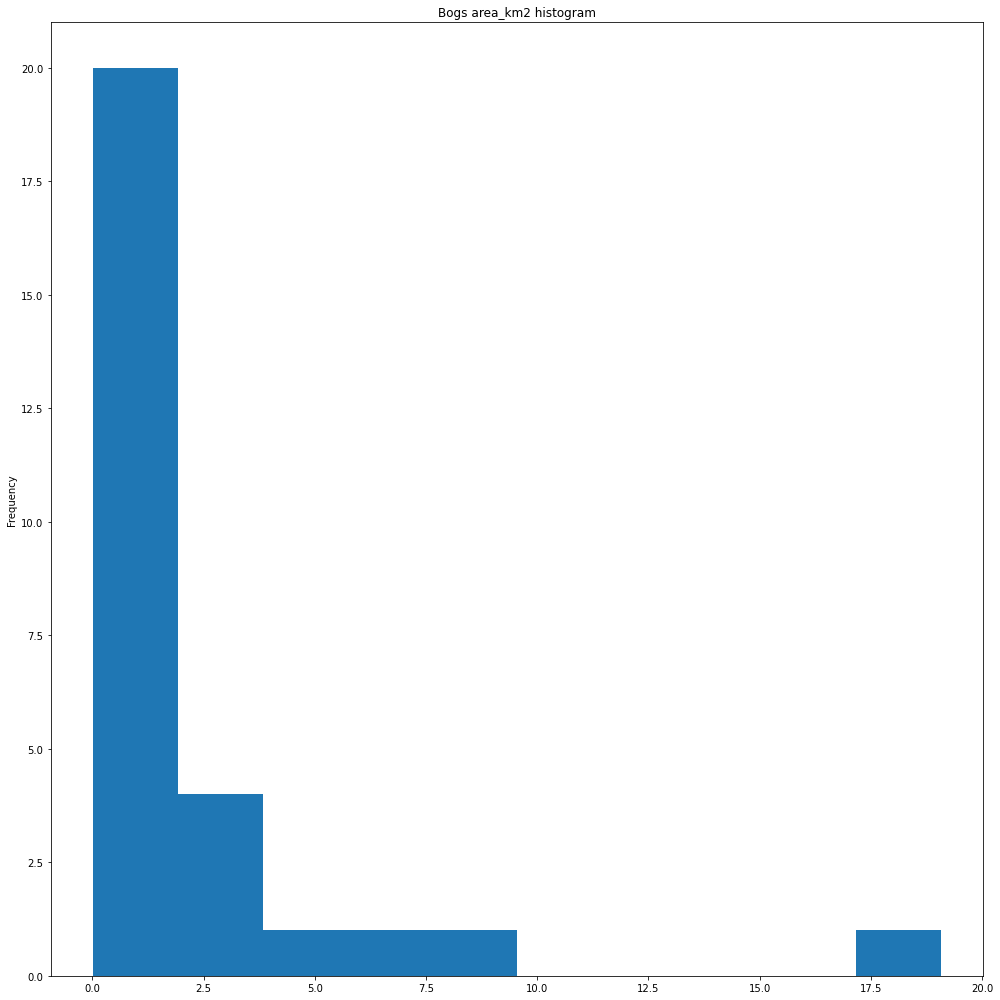

In [111]:
# Plot
fig, ax = plt.subplots()
bogs['area_km2'].plot.hist(bins=10);

# Add title
plt.title("Bogs area_km2 histogram")
plt.Text(0.5, 1.0, 'Bogs area_km2 histogram')

plt.tight_layout()

### Classifying data

#### Creating a custom classifier

Let’s create a function where we classify the geometries into two classes based on a given threshold -parameter. If the area of a polygon is lower than the threshold value (average size of the bog), the output column will get a value 0, if it is larger, it will get a value 1. This kind of classification is often called a binary classification.

First we need to create a function for our classification task. This function takes a single row of the GeoDataFrame as input, plus few other parameters that we can use.

In [112]:
def binaryClassifier(row, source_col, output_col, threshold):
    # If area of input geometry is lower that the threshold value
    if row[source_col] < threshold:
        # Update the output column with value 0
        row[output_col] = 0
    # If area of input geometry is higher than the threshold value update with value 1
    else:
        row[output_col] = 1
    # Return the updated row
    return row

In [113]:
bogs['small_big'] = None

C:\Anaconda\envs\geopy2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [114]:
bogs = bogs.apply(binaryClassifier, source_col='area_km2', output_col='small_big', threshold=l_mean_size, axis=1)

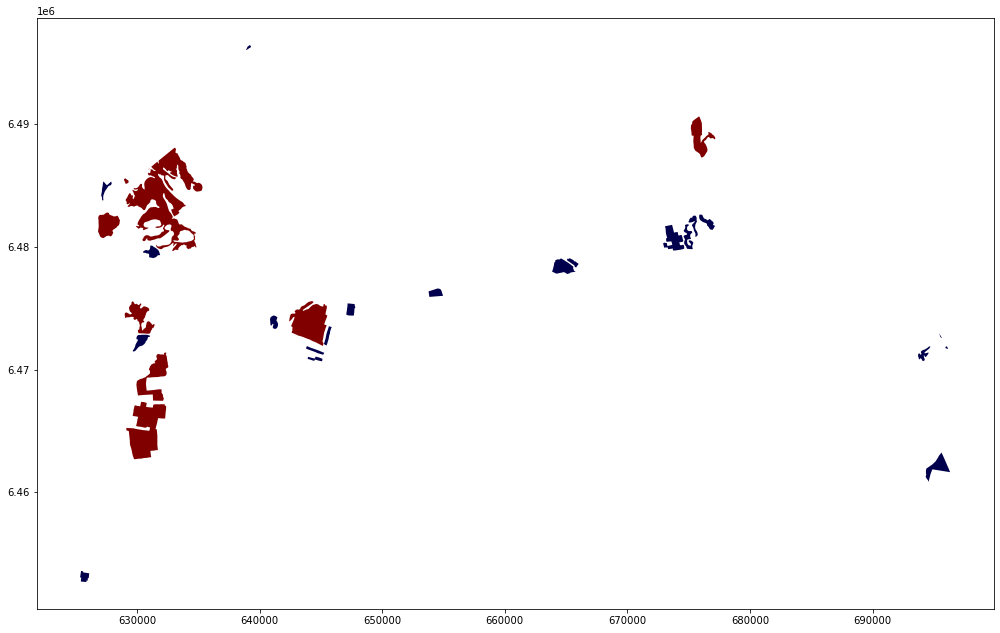

In [115]:
bogs.plot(column='small_big', linewidth=0.05, cmap="seismic")
plt.tight_layout()

In [116]:
outfp_bogs = "L4/bogs.shp"
bogs.to_file(outfp_bogs)

#### Classification based on common classification schemes

Pysal -module is an extensive Python library including various functions and tools to do spatial data analysis. It also includes all of the most common data classification schemes that are used commonly e.g. when visualizing data.

For this we will use the Adminstrative Units dataset for population. It is in the Estonian “vald” level, which compares to the level at municipality. It has the following fields:

- VID, an Id for the “vald”

- KOOD, a unique code for the Statistics Board

- NIMI, the name of the municipality

- population, the population, number of people living

- geometry, the polygon for the municpality district border

Let’s apply one of those schemes into our data and classify the population into 5 classes.

Choosing Number of Classes – if you choose too many classes then it requires the map reader to remember too much when viewing the map and it may also make the differentiation of class colors difficult for the map reader. On the other hand, if you choose too few classes, it oversimplifies the data possibly hiding important patterns. Additionally, each class may group dissimilar items together which is in direct opposition of one of the main goals of classification. Typically in cartography three to seven classes are preferred and five is the most common and optimal for most thematic maps.

In [117]:
fp = "L4/population_admin_units.shp"
acc = gpd.read_file(fp)
acc.head(5)

VID  KOOD          NIMI population  \
0  41158132.0  0698    Rõuge vald       5435   
1  41158133.0  0855    Valga vald      15989   
2  41158134.0  0732  Setomaa vald       3369   
3  41158135.0  0917     Võru vald      10793   
4  41158136.0  0142   Antsla vald       4514   

                                            geometry  
0  POLYGON ((646935.772 6394632.940, 647093.829 6...  
1  POLYGON ((620434.776 6406412.852, 620687.169 6...  
2  MULTIPOLYGON (((698977.677 6412793.362, 699094...  
3  POLYGON ((656207.141 6413138.438, 656408.394 6...  
4  POLYGON ((640706.698 6417414.068, 641029.597 6...

In [118]:
acc.dtypes

VID            float64
KOOD            object
NIMI            object
population      object
geometry      geometry
dtype: object

we have to change the column type for population into a numerical data type first: Here we demonstrate a more defensive strategy to convert datatypes. Many operations can cause Exceptions and then you can’t ignore the problem anymore because your code breaks. But with try - except we can catch expected exception (aka crashes) and react appropriately.

In [119]:
def change_type_defensively(row):
    try:
        return int(row['population'])
    except Exception:
        return np.nan

In [120]:
acc['population_int'] = acc.apply(change_type_defensively, axis=1)

Pandas (and therefore also Geopandas) also provides an in-built function that provides similar functionality to_numeric() , e.g. like so data['code_tonumeric_int'] = pd.to_numeric(data['code_12'], errors='coerce'). Beware, to_numeric() is called as pandas/pd function, not on the dataframe.

Both versions will at least return a useful NaN value (not_a_number, sort of a nodata value) without crashing.

It would be great to know the actual class ranges for the values. So let’s plot a histogram.

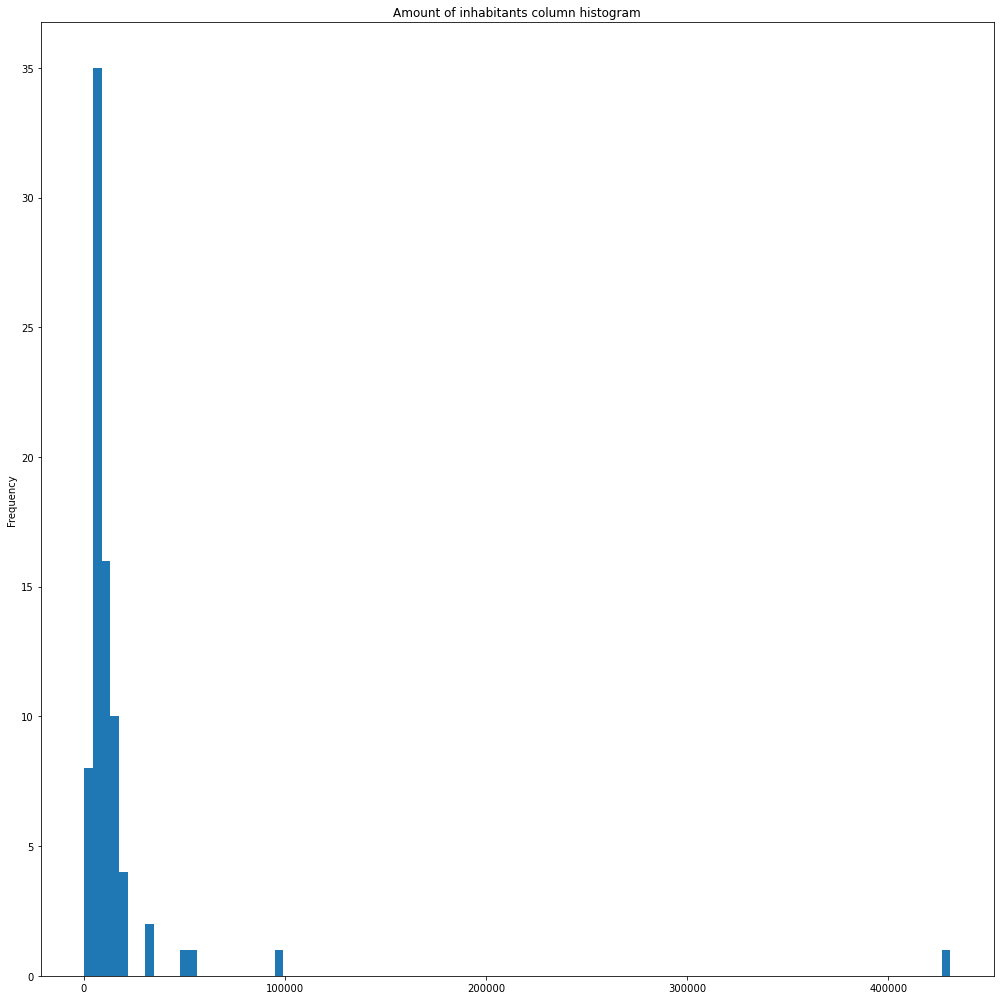

In [121]:
# Plot
fig, ax = plt.subplots()

acc["population_int"].plot.hist(bins=100);

# Add title
plt.title("Amount of inhabitants column histogram")
plt.Text(0.5, 1.0, 'Amount of inhabitants column histogram')

plt.tight_layout()

Now we can apply a classifier to our data quite similarly as in our previous examples.

In [122]:
import pysal.viz.mapclassify as mc

# Define the number of classes
n_classes = 5

The classifier needs to be initialized first with make() function that takes the number of desired classes as input parameter.

In [123]:
# Create a Natural Breaks classifier
classifier = mc.NaturalBreaks.make(k=n_classes)

Then we apply the classifier by explicitly providing it a column and then assigning the derived class values to a new column.

In [124]:
acc['population_classes'] = acc[['population_int']].apply(classifier)

# Let's see what we have
acc.head(3)

VID  KOOD          NIMI population  \
0  41158132.0  0698    Rõuge vald       5435   
1  41158133.0  0855    Valga vald      15989   
2  41158134.0  0732  Setomaa vald       3369   

                                            geometry  population_int  \
0  POLYGON ((646935.772 6394632.940, 647093.829 6...            5435   
1  POLYGON ((620434.776 6406412.852, 620687.169 6...           15989   
2  MULTIPOLYGON (((698977.677 6412793.362, 699094...            3369   

   population_classes  
0                   0  
1                   1  
2                   0

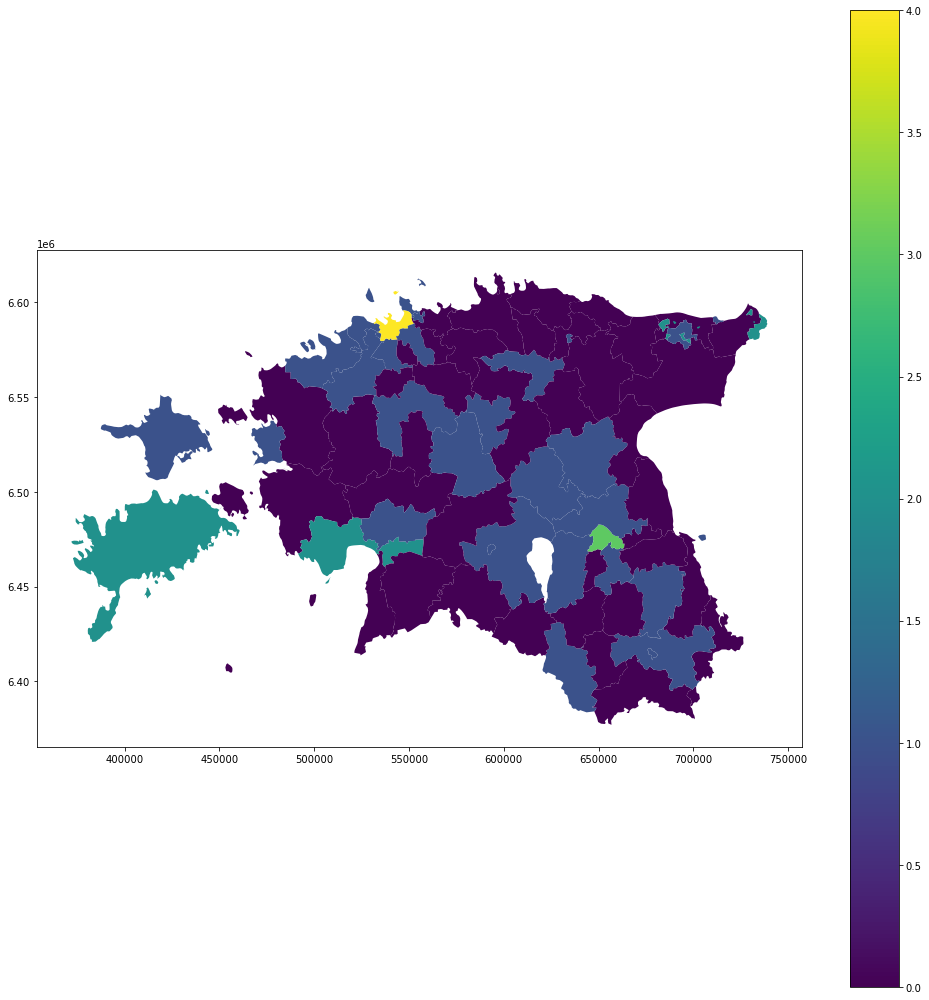

In [125]:
acc.plot(column="population_classes", linewidth=0, legend=True);

# Use tight layour
plt.tight_layout()

In order to get the min() and max() per class group, we use groupby again.

In [126]:
grouped = acc.groupby('population_classes')

# legend_dict = { 'class from to' : 'white'}
legend_dict = {}

for cl, valds in grouped:
    minv = valds['population_int'].min()
    maxv = valds['population_int'].max()
    print("Class {}: {} - {}".format(cl, minv, maxv))

Class 0: 141 - 8984
Class 1: 9387 - 21406
Class 2: 31205 - 56103
Class 3: 96506 - 96506
Class 4: 430805 - 430805


And in order to add our custom legend info to the plot, we need to employ a bit more of Python’s matplotlib magic:

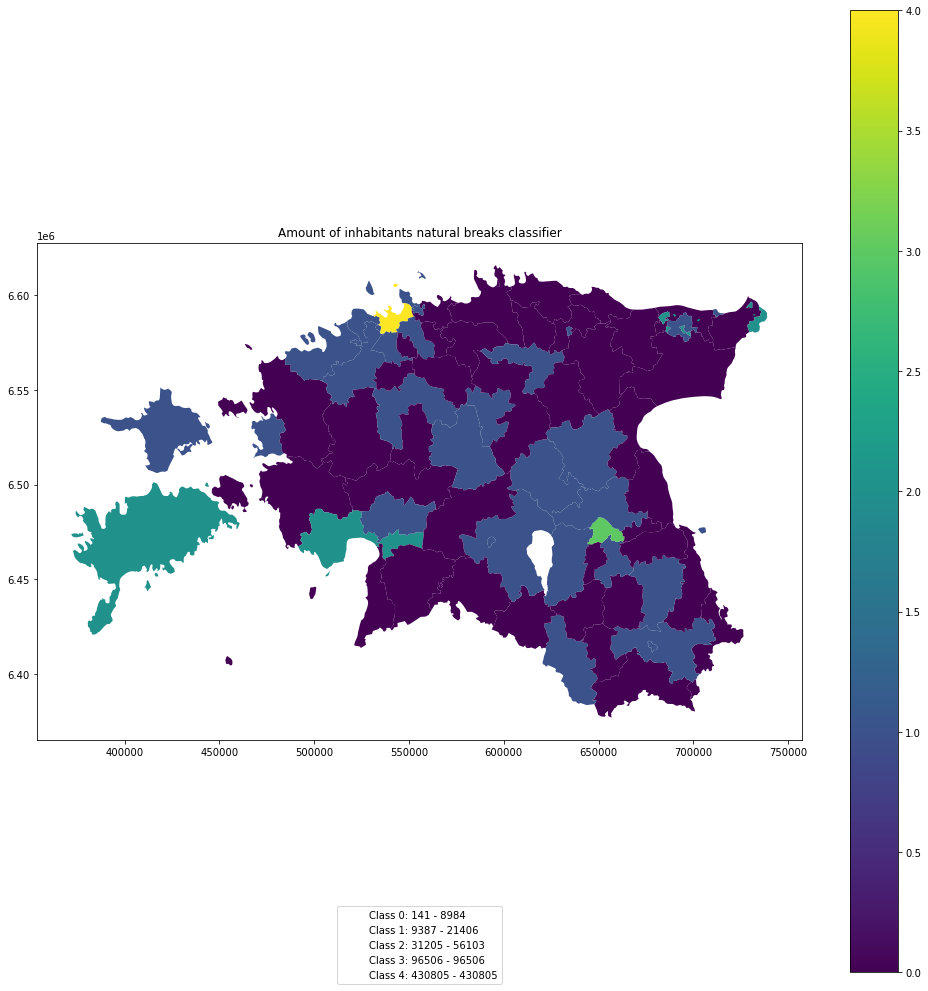

In [127]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import collections

# legend_dict, a special ordered dictionary (which reliably remembers order of adding things) that holds our class description and gives it a colour on the legend (we leave it "background" white for now)
legend_dict = collections.OrderedDict([])

#
for cl, valds in grouped:
    minv = valds['population_int'].min()
    maxv = valds['population_int'].max()
    legend_dict.update({"Class {}: {} - {}".format(cl, minv, maxv): "white"})

# Plot preps for several plot into one figure
fig, ax = plt.subplots()

# plot the dataframe, with the natural breaks colour scheme
acc.plot(ax=ax, column="population_classes", linewidth=0, legend=True);

# the custom "patches" per legend entry of our additional labels
patchList = []

for key in legend_dict:
    data_key = mpatches.Patch(color=legend_dict[key], label=key)
    patchList.append(data_key)

# plot the custom legend
plt.legend(handles=patchList, loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=1)

# Add title
plt.title("Amount of inhabitants natural breaks classifier")

plt.tight_layout()

# Lesson 5

During this lesson we will learn to work with Raster data, the other commonly used GIS data type:

- Working with Raster data

- Calculating NDVI and Hillshading

After this lesson’s lesson you should be able to:

- understand the Raster data model, and the difference to vector/feature data

- load and analyse raster datasets with RasterIO and RasterStats

- do raster algebra, basic satellite data processing (NDVI) and hillshading with EarthPy

- plot, extract and save raster data files

## Working with Raster data

### Data Structures Recap: Raster and Vector

The two primary types of geospatial data are raster and vector data:

- Vector data structures represent specific features on the Earth’s surface, and assign attributes to those features.

- Raster data is stored as a grid of values which are rendered on a map as pixels. Each pixel value represents an area on the Earth’s surface.

Common properties of any raster:

- number of rows and columns (sometimes referred to as lines and samples)

- data type (dtype, or bit depth) - e.g., 8-bit (2^8 possible values, 0-255)

- some kind of resolution information, often dots per inch (dpi) with raster graphics


#### Examples of continuous rasters

A map of elevation for Harvard Forest derived from the NEON AOP LiDAR sensor is below. Elevation is represented as continuous numeric variable in this map. The legend shows the continuous range of values in the data from around 300 to 420 meters.
- heat
- elevation
- density

#### Examples of categorical rasters


Some rasters contain categorical data where each pixel represents a discrete class such as a landcover type (e.g., “coniferous forest” or “grassland”) rather than a continuous value such as elevation or temperature. Some examples of classified maps include:

- Landcover / land-use maps

- Snowcover masks (binary snow or no snow)

### Raster Advantages and Disadvantages

Advantages:

- efficient representation of continuous surfaces

- cell-by-cell calculations can be very fast and efficient

- potentially very high levels of detail

- data is ‘unweighted’ across its extent

Disadvantages:

- very large file sizes as cell size gets smaller

- can be difficult to represent complex information

- Measurements are spatially arranged in a regular grid, which may not be an accurate representation of real-world phenomena

- Space-filling model assumes that all pixels have value

- Changes in resolution can drastically change the meaning of values in a dataset

### What makes a raster geospatial?

A raster is just an image in local pixel coordinates until we specify what part of the earth the image covers. This is done through two fundamental pieces of metadata that accompany the pixel values of the image:

1. Coordinate Reference System or “CRS”
2. Geotransformation (This is the essential matrix that relates the raster pixel coordinates (rows, columns) to the geographic coordiantes (x and y defined by the CRS). This is typically a 6-parameter transformation that defines the origin, pixel size and rotation of the raster in the geographic coordinate system:)

Defining this for the whole image allows the image’s pixels to be referenced by a local array index rather than global coordinates, and answers questions such as:

- How much area does a given pixel cover?

- Given the CRS, what is the origin?

- In what direction does the raster “grow” as pixel indices increase?

3. Extent / BBOX 
The affine transformation specifies an “extent” or “bounding box”, which is defined by the minimum and maximum x and y coordinates of the data.

4. Resolution / Posting The affine transformation specifies a pixel size of the area on the ground that each pixel of the raster covers. This is often refered to as “resolution”, but because images are often resampled to different resolutions it is also refered to as “posting” or “ground sample distance (gsd)”. Ultimately, “resolution” refers to a sensors ability to distinguish different objects on the ground.

### Multi-band Raster Data

A raster can contain one or more bands. In a multi-band dataset, the rasters will always have the same extent, resolution, and CRS. Each band represents light reflected (or emmitted) from the different portions of the electromagnetic spectrum. The pixel brightness for each band, when composited creates the colors that we see in an image.

Multi-band raster data might also contain:

- Time series: the same variable, over the same area, over time

- Multi or hyperspectral imagery: image rasters that have 4 or more (multi-spectral) or more than 10-15 (hyperspectral) bands

### Conclusion

- Raster data is pixelated data stored as a matrix

- Raster images are often packaged as multidimensional arrays - containing for example RGB and other spectral bands

- Geospatial raster data always has a coordinate reference system (CRS) and geotransform that maps image coordinates to locations on Earth’s surface

- People often refer to “resolution” as the ground pixel size of a raster, but more specifically it refers to the sensor’s ability to disabiguate adjacent objects on the ground

## Exploring and visualisation of raster data

Rasterio is a very useful module for raster processing which you can use for reading and writing several different raster formats in Python. Rasterio is based on GDAL and Python automatically registers all known GDAL drivers for reading supported formats when importing the module. Most common file formats include for example TIFF and GeoTIFF, ASCII Grid and Erdas Imagine .img -files.

Download example tif raster file forest_loss_porijogi_wgs84.tif

This is a categorical raster containing one band, which is representing the measured (by satellite) forest loss of the years 2001-2018. Each raster cell should have a value, from 0 to 18, representing 0: no forest loss, or one of the numbers 1-18, indicating forest less in this cell in the year 20xx.

In [128]:
import rasterio
dataset = rasterio.open('L5/forest_loss_porijogi_wgs84.tif')

In [129]:
print(dataset.name)

print(dataset.mode)

print(dataset.count)

print(dataset.width)

print(dataset.height)

print(dataset.crs)

print(dataset.bounds)

L5/forest_loss_porijogi_wgs84.tif
r
1
1326
687
EPSG:4326
BoundingBox(left=26.548502689, bottom=58.117685726, right=26.880002689, top=58.289435726)


Another interesting, slightly more complex, attribute is the profile. Where we can quickly see a variety of important aspects. As explained above in the introduction, this is the Geotransformation / Geotransform:

In [130]:
print(dataset.profile)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 128.0, 'width': 1326, 'height': 687, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002500000000000014, 0.0, 26.548502689,
       0.0, -0.0002500000000000043, 58.289435726), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


Each raster dataset can have several so called bands. Each band in Python and Rasterio is essentially handled as a Numpy array, ndarray. The same computationally efficient data structure that also underlies our Pandas dataframes.

In [131]:
band1 = dataset.read(1)
band1

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0, 17, 17, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int16)

And similarly to other plotting mechanisms, like we use for Pandas or Geopandas, we use matplotlib for the foundational functionality. Now, as we learned, raster datasets are essentially “just” pixels in a properly organized grid - an image - we can use default plotting from matplotlib and numpy to plot a basic 2D image.

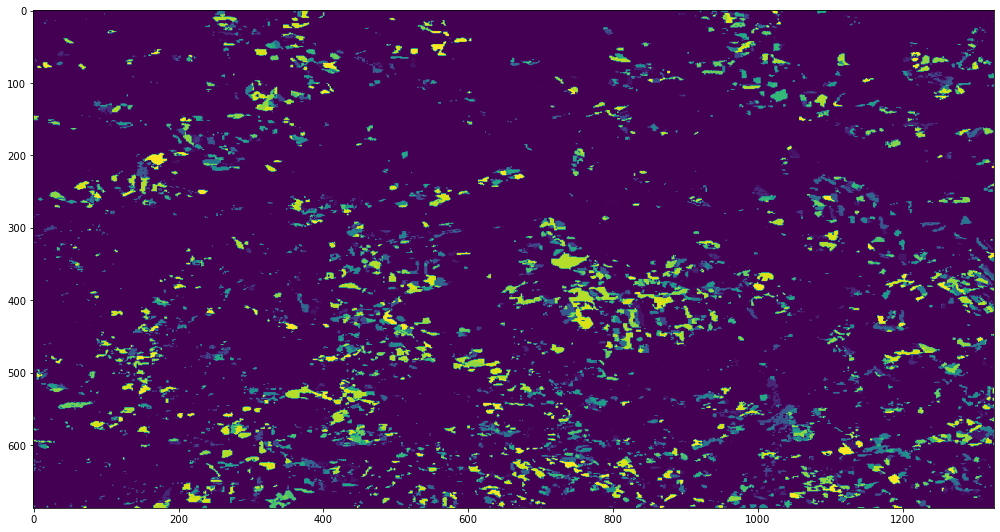

In [132]:
plt.imshow(band1)
plt.tight_layout()

For convenience, Rasterio provides its own slightly advancd plot method, called show(), where we can either add the whole dataset or specific bands. In order to retain the geotransform logic when plotting a rasterio image, it is of advantage to use the tuple-based nomenclature:

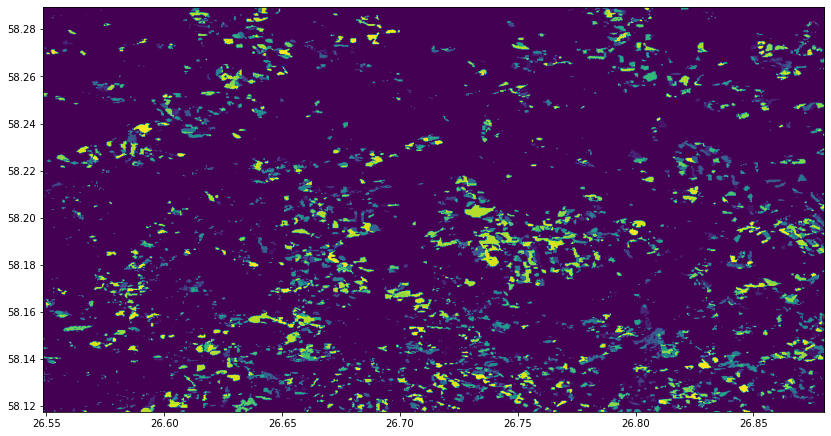

<Figure size 1008x1008 with 0 Axes>

In [133]:
from rasterio.plot import show

# band1 is just a numpy ndarray
# show(band1)
# a tuple -> (dataset, 1) indicating the first band in the raster dataset
# show((dataset, 1))
# the whole dataset, eg. RGB bands making up the normal colorspctrum
show(dataset)

plt.tight_layout()

Let’s dig deeper into our categorical raster. We use numpy’s unique function to extract all occurring unique values (in our case: the year-based classes). And then we manually calculate the histgram with numpy, too:

In [134]:
uniq_vals = np.unique(band1)

# display sorted order
print(sorted(uniq_vals))

# Patches = the matplotlib objects drawn
counts, bins = np.histogram(band1, bins=18)

# Print histogram outputs
for i in range(len(bins)-1):
    print("bin lower bound:", bins[i])
    print("counts:", counts[i])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
bin lower bound: 0.0
counts: 815440
bin lower bound: 1.0
counts: 4269
bin lower bound: 2.0
counts: 4179
bin lower bound: 3.0
counts: 1076
bin lower bound: 4.0
counts: 3273
bin lower bound: 5.0
counts: 4023
bin lower bound: 6.0
counts: 4418
bin lower bound: 7.0
counts: 3327
bin lower bound: 8.0
counts: 4611
bin lower bound: 9.0
counts: 3576
bin lower bound: 10.0
counts: 3983
bin lower bound: 11.0
counts: 5469
bin lower bound: 12.0
counts: 3706
bin lower bound: 13.0
counts: 2764
bin lower bound: 14.0
counts: 5237
bin lower bound: 15.0
counts: 6990
bin lower bound: 16.0
counts: 13465
bin lower bound: 17.0
counts: 21156


Now, a short side note on adding a custom legend to our plot. Sometimes, we can’t get the legend information from the image, so provide it directly. We use the “viridis” colormap as a base, which is a colorband with 256 colors forming the spectrum of this colormap. We then evenly take color definition elements out of that colormap and assign them to our classes. The even steps are derived from the number of values in our raster dataset, i.e. in this particular nump ndarray.

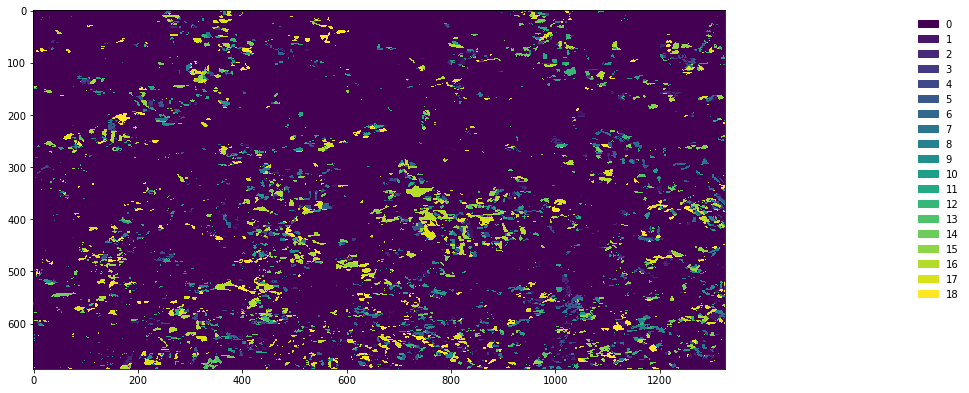

In [135]:
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm
from matplotlib import rcParams, cycler

fig, ax = plt.subplots()

cmap = plt.cm.viridis

lst = [int(x) for x in np.linspace(0,255,19)]

legend_patches = [Patch(color=icolor, label=label) for icolor, label in zip( cmap(lst), sorted(uniq_vals))]

ax.legend(handles=legend_patches, facecolor="white", edgecolor="white", bbox_to_anchor=(1.35, 1))

plt.imshow(band1, cmap=cmap, interpolation='nearest')

plt.tight_layout()

It also always advisable to look at the distribution of values visually, like a histogram plot:

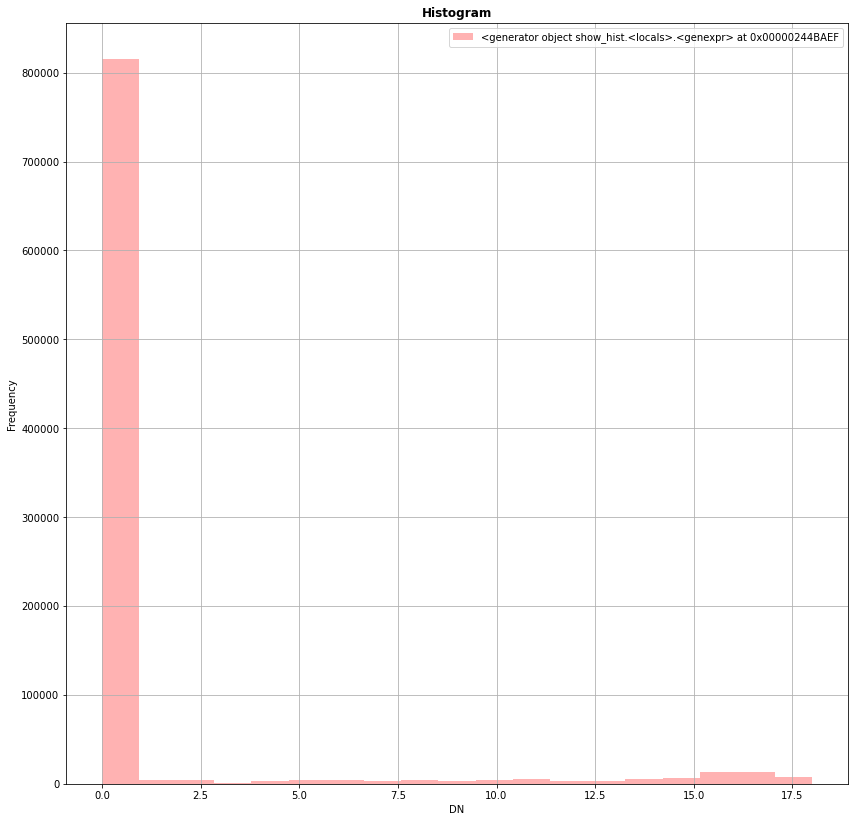

<Figure size 1008x1008 with 0 Axes>

In [136]:
from rasterio.plot import show_hist
show_hist(dataset, bins=19, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")
plt.tight_layout()

With matplotlib it is also easy to build multi-figure plots:

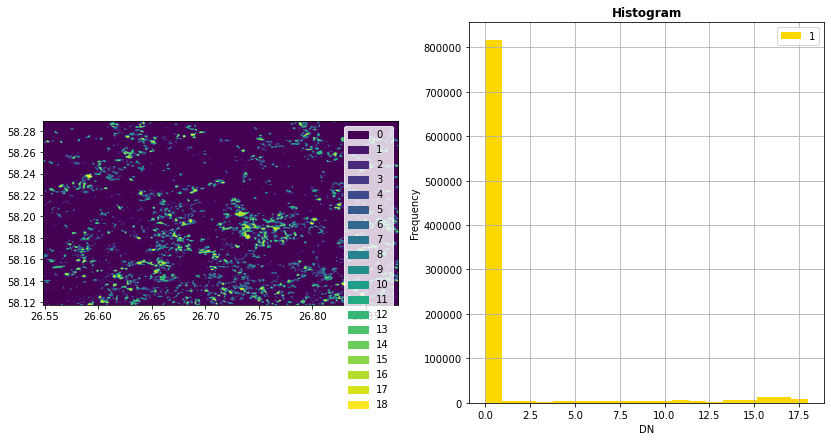

<Figure size 1008x1008 with 0 Axes>

In [137]:
fig, (ax_dat, ax_hist) = plt.subplots(1, 2, figsize=(14,7))

ax_dat.legend(handles=legend_patches, facecolor="white", edgecolor="white")

show((dataset, 1), ax=ax_dat)

show_hist((dataset, 1), bins=19, ax=ax_hist)

plt.show()

plt.tight_layout()

## Reproject a raster

As we learned before, in order to perform meaning spatial operations and analyses, we need to make sure that our spatial datasets are in the same coordinate reference system. In addition, if we want to make assumptions about distances or areas we should consider using a projected coordinate reference system that has its units of measurement defined in e.g. metres. This is the same for raster data, where each pixel represents a certain area. Typically, all pixels are assumed to represent the same size.

In order to reproject a raster, we have to get a bit more involved. But before we get in-depth, a short side-note on Python resources handling. When files are opened, they are controlled by the Python process through a so called filehandle. If these filehandles are not closed properly, it can cause problems, such as data not been written to the harddisk, several filehandles looking at the same file causing undefind behaviour, or general resource-shortage, which becomes a problem, when many thousands of files are opened but not closed.

Python provides also a more “sophisticated” way, in the form similar to the “for” comprehensions that we use to go over lists, etc. Here Python manages not the iterating for us, but the opening and closing of the file. Everything in the with block below is safe, and once the block is completed, the flush and close are managed by Python and the file is safely and reliably written and closed. We will see this pattern today occasionally.

Now let’s reproject the forest loss example tif from WGS84 to the Estonian grid 1997, aka EPSG:3301. FYI, We are still using the same example tif raster file forest_loss_porijogi_wgs84.tif.

In [138]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:3301'

with rasterio.open('L5/forest_loss_porijogi_wgs84.tif') as src:
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open('L5/forest_loss_porijogi_3301.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

A lot of stuff happened here:

1. We do the imports and then we define our target CRS. No surprises here. Then we open a first with block to open our source dataset.

2. we calculate a standard transformation (the pre-calculation so to say) calculate_default_transform with the information from source dataset and the taret CRS.

3. We copy the metadata from the original source dataset into a dictionary object kwargs (keyword arguments, just a structure with additional parameters and values)

4. We update some important information in the kwargs object, in particular the newly calulated values for transform and CRS

5. We are still within the first with block for reading the source, and now open a nested new with block for writing the projected data to file.

6. For each band then we do the actual reproject with the calculated parameters from source to destination.

Let’s open the written file to look at it.

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 128.0, 'width': 1107, 'height': 1088, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(18.286653237913256, 0.0, 649439.5163138955,
       0.0, -18.286653237913256, 6464597.241364005), 'tiled': False, 'interleave': 'band'}


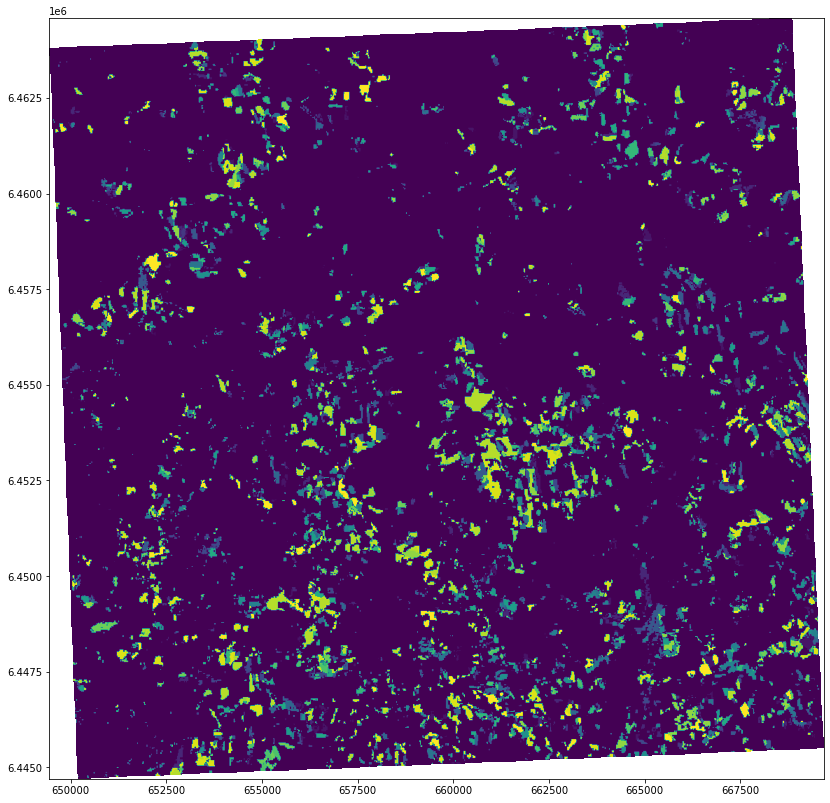

In [139]:
# quickly load and check
with rasterio.open('L5/forest_loss_porijogi_3301.tif', 'r') as data2:
    print(data2.profile)
    show(data2, cmap=cmap)

## Clipping a raster

One common task in raster processing is to clip raster files based on a Polygon. We will reuse the Porijõgi GeoJSON-file from last lecture or download here porijogi_sub_catchments.geojson.

In [140]:
catchments = gpd.read_file('L3/porijogi_sub_catchments.geojson')
print(catchments.crs) 
print(catchments.head(5))

epsg:3301
   OBJECTID     NAME_1       AREA_1    Shape_Leng    Shape_Area  ID  \
0         8     Idaoja  3823.427995  35446.162219  3.823428e+07   1   
1         9  Keskjooks  5087.809731  42814.174755  5.087810e+07   2   
2        10      Peeda  5634.162684  47792.268153  5.634163e+07   3   
3        11       Sipe   890.280919  16449.028656  8.902809e+06   4   
4        12      Tatra  3306.643841  31108.960376  3.306644e+07   5   

                                            geometry  
0  MULTIPOLYGON (((660834.858 6455555.914, 660851...  
1  MULTIPOLYGON (((666339.502 6455972.600, 666384...  
2  MULTIPOLYGON (((659914.002 6456514.131, 659817...  
3  MULTIPOLYGON (((665928.914 6460634.243, 665985...  
4  MULTIPOLYGON (((658678.470 6457825.152, 658579...  


In order to use the features, technically only the polygon geometries, for clipping in Rasterio, we need to provide them in a slightly more low-level format. We remember that the fiona library works actually under the hood of our now well-known Geopandas library. With fiona we can open vector/feature datasets directly without loading them into a dataframe. Here we extract the “low-level” geometry object with fiona in order to obtain our vector mask.

In [141]:
import fiona
with fiona.open("L3/porijogi_sub_catchments.geojson", "r") as vectorfile:
    shapes = [feature["geometry"] for feature in vectorfile]

With this list shapes that we just created we can pass the polygons to the mask function of Rasterio to do the clipping. The clipping itself is pretty straightfoward. Here we demonstrate the opening of the raster dataset without a with block, so simply opening it and working with the filehandle thereof, and eventually closing it again.

In [142]:
from rasterio.mask import mask

# we have to use the newly created reprojected raster file
data2 = rasterio.open('L5/forest_loss_porijogi_3301.tif', 'r')

# Clip the raster with Polygon
out_image, out_transform = mask(dataset=data2, shapes=shapes, crop=True)

out_meta = data2.meta.copy()

data2.close()

The whole work during the clipping process is very similar to the reprojecting workflow. As we change the dimension of the raster data, because we are literally clipping stuff off it, we have to retrieve a new transform together with the raw data. We keep some of the original meta information again, but we update of course dimensions and transform before we write the new dataset to file.

In [143]:
print(out_meta)

out_meta.update({"driver": "GTiff",
             "height": out_image.shape[1],
             "width": out_image.shape[2],
             "transform": out_transform})

with rasterio.open("L5/forest_loss_clipped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 128.0, 'width': 1107, 'height': 1088, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(18.286653237913256, 0.0, 649439.5163138955,
       0.0, -18.286653237913256, 6464597.241364005)}


{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 128.0, 'width': 1072, 'height': 1034, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(18.286653237913256, 0.0, 649896.6826448432,
       0.0, -18.286653237913256, 6464158.361686295), 'tiled': False, 'interleave': 'band'}


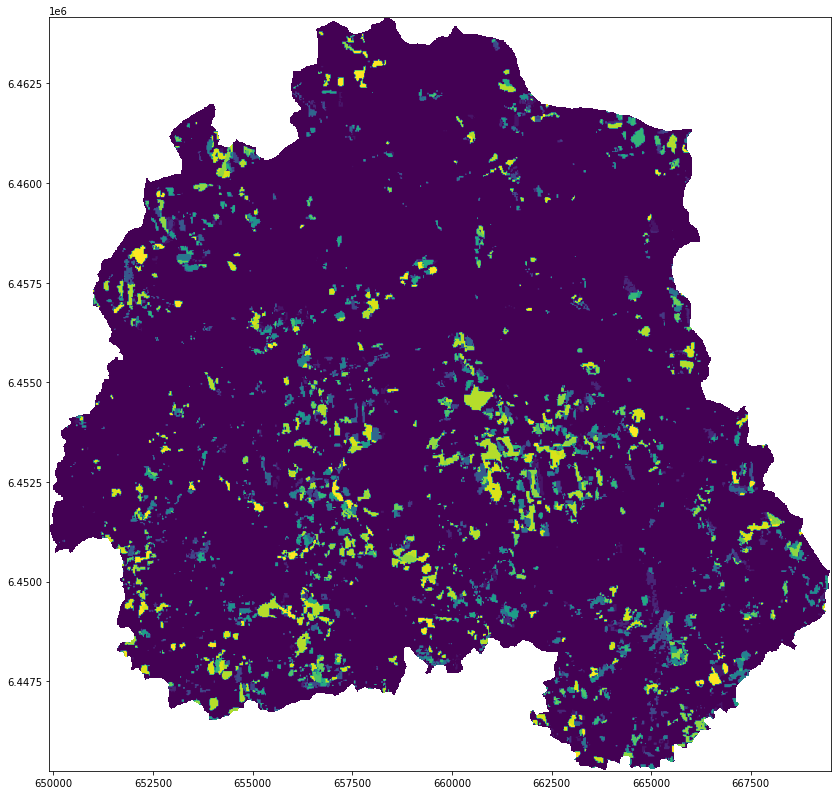

In [144]:
with rasterio.open('L5/forest_loss_clipped.tif', 'r') as data3:
    print(data3.profile)
    show(data3, cmap=cmap)

## Calculating zonal statistics

Often we want to summarize raster datasets based on vector geometries, such as calculating the average elevation of specific area or aggregating summaries of areas or other count-based statistics per pixel under given polygons. Rasterstats is a Python module that works on top of Rasterio and does exactly that.

In [145]:
catchments = gpd.read_file('L3/porijogi_sub_catchments.geojson')

Continuous raster are representing a continuous surface of the distribution of a phenomenon in space - e.g. elevation or temperature. DEMs are continuous rasters and now we want to look at a Digital Elevation Model (DEM) raster file: dem.tif.

In [146]:
demdata = rasterio.open('L5/dem.tif')

print(demdata.name)

print(demdata.mode)

print(demdata.count)

print(demdata.width)

print(demdata.height)

print(demdata.crs)

print(demdata.bounds)

L5/dem.tif
r
1
1020
1065
EPSG:3301
BoundingBox(left=644405.5556, bottom=6443988.8889, right=675000.5556, top=6475948.8889)


And we can also plot vector features and raster datasets together: Again, we make sure we are plotting on top of the same “axes”, we use the Rasterio show function and tell it to plot the the first band in the demdata dataset, and then we plot our Geopandas dataframe on top of it. We have to be sure of course, that our datasets are in the same spatial coordinate reference system.

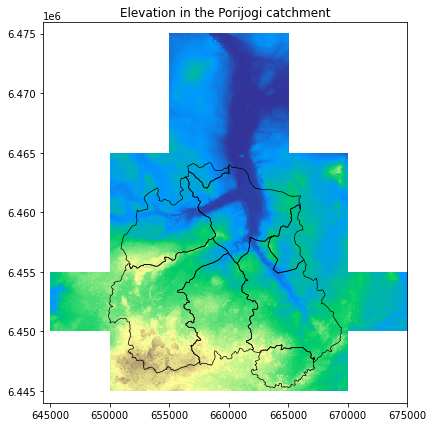

<Figure size 1008x1008 with 0 Axes>

In [147]:
fig, ax = plt.subplots(1, figsize=(9, 7))

show((demdata, 1), cmap='terrain', interpolation='none', ax=ax)

catchments.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)

plt.title("Elevation in the Porijogi catchment")

plt.show()

plt.tight_layout()

Importing and calling the zonal statistics function from the Rasterstats module is very easy. However, we have to be aware that we directly refer to the file paths of the datasets, and not to a variable containing a numpy array or dataframe! We can name the desired statistics via the stats parameter. Check the detailed API which statistics are available.

In [148]:
from rasterstats import zonal_stats
zs = zonal_stats('L3/porijogi_sub_catchments.geojson', 'L5/dem.tif', stats=['mean','std'])
print(zs)

[{'mean': 108.81127854956439, 'std': 20.45245360418255}, {'mean': 86.88054631660887, 'std': 16.95209830197268}, {'mean': 122.27791004234241, 'std': 25.821034407200845}, {'mean': 76.41216968715197, 'std': 6.690340937594575}, {'mean': 82.89976042687574, 'std': 23.864544169477856}, {'mean': 66.31877151178183, 'std': 6.77909304322478}, {'mean': 112.26344569806881, 'std': 15.545179792343868}, {'mean': 59.404531339850486, 'std': 16.974837452873903}]


## Exercise 2: Freeroaming with raster data

Laseraltimetrie opname van het gebied Huibertgat in de Waddenzee (DTM 5 meter).

In [149]:
dataset = rasterio.open('L5/waddenzee_huibertgat_2019_dsm_5.tif')

In [150]:
print(dataset.name)

print(dataset.mode)

print(dataset.count)

print(dataset.width)

print(dataset.height)

print(dataset.crs)

print(dataset.bounds)

L5/waddenzee_huibertgat_2019_dsm_5.tif
r
1
9000
5000
PROJCS["Amersfoort / RD New",GEOGCS["Amersfoort",DATUM["Amersfoort",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6289"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",52.1561605555556],PARAMETER["central_meridian",5.38763888888889],PARAMETER["scale_factor",0.9999079],PARAMETER["false_easting",155000],PARAMETER["false_northing",463000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
BoundingBox(left=210000.0, bottom=600000.0, right=255000.0, top=625000.0)


In [151]:
print(dataset.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.4028234663852886e+38, 'width': 9000, 'height': 5000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Amersfoort / RD New",GEOGCS["Amersfoort",DATUM["Amersfoort",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6289"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",52.1561605555556],PARAMETER["central_meridian",5.38763888888889],PARAMETER["scale_factor",0.9999079],PARAMETER["false_easting",155000],PARAMETER["false_northing",463000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(5.0, 0.0, 210000.0,
       0.0, -5.0, 625000.0), 'blockxsize': 9008, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [152]:
band1 = dataset.read(1)
band1

array([[3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       ...,
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38]], dtype=float32)

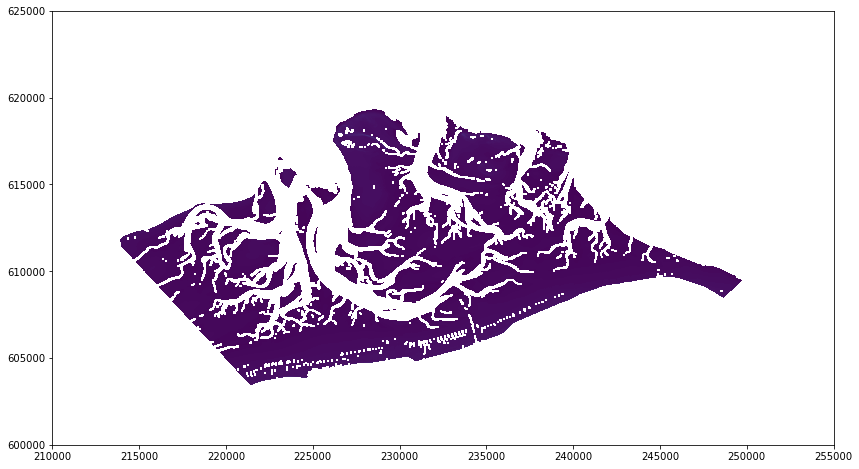

<Figure size 1008x1008 with 0 Axes>

In [153]:
from rasterio.plot import show

# band1 is just a numpy ndarray
# show(band1)
# a tuple -> (dataset, 1) indicating the first band in the raster dataset
# show((dataset, 1))
# the whole dataset, eg. RGB bands making up the normal colorspctrum
show(dataset)

plt.tight_layout()

Import shapefile of the whole Waddenzee

In [154]:
catchments = gpd.read_file('L5/pkb_in_waddenzee.shp')
print(catchments.crs) 
print(catchments.head(5))

epsg:28992
   OBJECTID  FID_1                                           geometry
0       1.0    0.0  POLYGON ((112990.534 557373.237, 112988.283 55...


Plotting the laseraltimetrieit within the shapefile of the Waddenzee

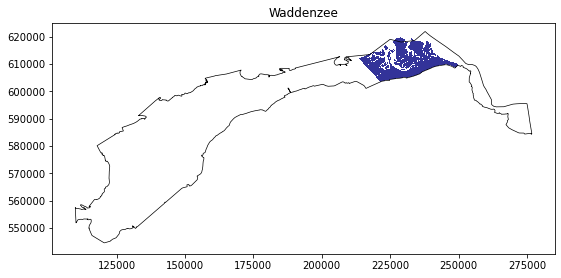

<Figure size 1008x1008 with 0 Axes>

In [155]:
fig, ax = plt.subplots(1, figsize=(9, 7))

show((dataset, 1), cmap='terrain', interpolation='none', ax=ax)

catchments.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)

plt.title("Waddenzee")

plt.show()

plt.tight_layout()

## Lesson 6

This lesson we will focus on learning how to create beautiful maps in Python with different levels of interactivity and modes of presentation.

There are many different Python modules that can be used for making visualizations. And many of them allows you to create also different kinds of maps. During this lesson we will focus on few of them, namely:

- Matplotlib (static maps, integrated into Geopandas and Matplotlib)

- Geoplot (static maps for specific use cases, based on Matplotlib)

- EarthPy (additional support for better raster data maps, based on Matplotlib)

- Bokeh (interactive plots)

- GeoViews (interactive maps based on Bokeh, can also make static maps with support of Matplotlib)

- Folium (interactive Web maps on Leaflet)

## Static maps with matplotlib

You should have following Shapefiles in the Data folder:

population_square_km.shp

schools_tartu.shp

roads.shp

### Static maps in Geopandas

Let’s create a static neighbourhood map with roads and schools line on it and population density as a background.

In [156]:
# Filepaths
grid_fp = "L6/population_square_km.shp"

roads_fp = "L6/roads.shp"

schools_fp = "L6/schools_tartu.shp"

# Read files
grid = gpd.read_file(grid_fp)

roads = gpd.read_file(roads_fp)

schools = gpd.read_file(schools_fp)

Then, we need to be sure that the files are in the same coordinate system. Let’s use the crs of our travel time grid.

In [157]:
gridCRS = grid.crs
roads['geometry'] = roads['geometry'].to_crs(crs=gridCRS)
schools['geometry'] = schools['geometry'].to_crs(crs=gridCRS)

Finally we can make a visualization using the .plot() -function in Geopandas. The .plot() function takes all the matplotlib parameters where appropriate. For example we can adjust various parameters

- ax if used, then can indicate a joint plot axes onto which to plot, used to plot several times (several layers etc) into the same plot (using the same axes, i.e. x and y coords)

- column which dataframe column to plot

- linewidth if feature with an outline, or being a line feature then line width

- markersize size of point/marker element to plot

- color colour for the layers/feature to plot

- cmap colormaps (*cmap* - parameter)

- alpha transparency 0-1

- legend True/False show the legend

- scheme one of 3 basic classification schemes (“quantiles”, “equal_interval”, “fisher_jenks”), beyond that use PySAL explicitly

- k number of classes for above scheme if used.

- vmin indicate a minimal value from the data column to be considered when plotting (also affects the classification scheme), can be used to “normalise” several plots where the data values don’t aligh exactly

- vmax indicate a maximal value from the data column to be considered when plotting (also affects the classification scheme), can be used to “normalise” several plots where the data values don’t aligh exactly

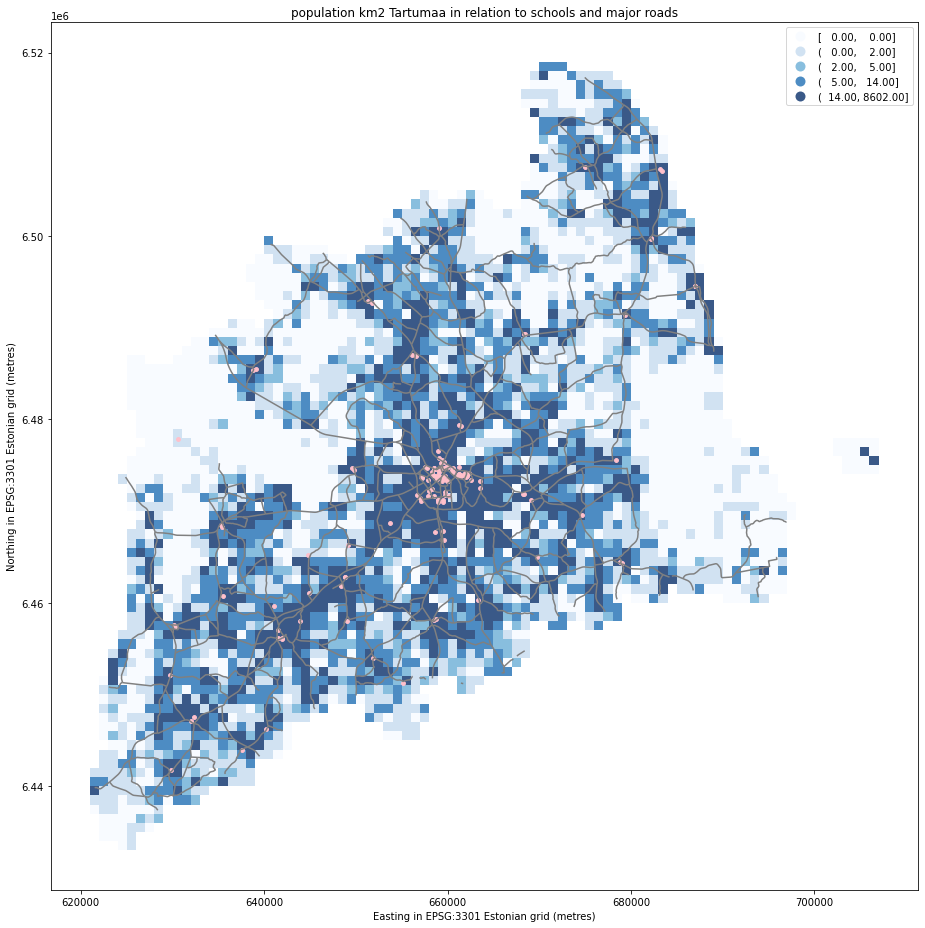

In [158]:
fig, ax = plt.subplots(figsize=(15, 13))

# Visualize the population density into 5 classes using "Quantiles" classification scheme
# Add also a little bit of transparency with `alpha` parameter
# (ranges from 0 to 1 where 0 is fully transparent and 1 has no transparency)
grid.plot(column="Population", ax=ax, linewidth=0.03, cmap="Blues", scheme="quantiles", k=5, alpha=0.8, legend=True)

# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=ax, color="grey", linewidth=1.5)

# Add schools on top of the previous map
schools.plot(ax=ax, color="pink", markersize=15.0)

# Remove the empty white-space around the axes
plt.title("population km2 Tartumaa in relation to schools and major roads")

ax.set_ylabel('Northing in EPSG:3301 Estonian grid (metres)')
ax.set_xlabel('Easting in EPSG:3301 Estonian grid (metres)')

plt.tight_layout()

In [159]:
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)

<Figure size 1008x1008 with 0 Axes>

### Interactive maps with Bokeh

#### Simple interactive plot

In [160]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [161]:
# Initialize the plot (p) and give it a title
p = figure(title="My first interactive plot!")

In [162]:
p

Figure(id='1003', ...)

Next we need to create lists of x and y coordinates that we want to plot.

In [163]:
x_coords = [0,1,2,3,4]

# Create a list of y-coordinates
y_coords = [5,4,1,2,0]

Now we can plot those as points using a .circle() -object. Let’s give it a red color and size of 10.

In [164]:
# Plot the points
p.circle(x=x_coords, y=y_coords, size=10, color="pink")

GlyphRenderer(id='1043', ...)

In [165]:
show(p)

In [166]:
outfp = "point_map.html"

# Save the map
output_file(outfp)

### Creating interactive maps using Bokeh and Geopandas

Now we now khow how to make a really simple interactive point plot using Bokeh. What about creating such a map from a Shapefile of points? Of course we can do that, and we can use Geopandas for achieving that goal which is nice!

Creating an interactive Bokeh map from Shapefile(s) contains typically following steps:

1. Read the Shapefile into GeoDataFrame

2. Calculate the x and y coordinates of the geometries into separate columns

3. Convert the GeoDataFrame into a Bokeh DataSource

4. Plot the x and y coordinates as points, lines or polygons (which are in Bokeh words: circle, multi_line and patches)

#### Point map

Let’s first make a map out schools address points in Tartumaa. That Shapefile is provided for you in the data folder that you downloaded.

Read the data using geopandas which is the first step.

In [167]:
points_fp = "L6/schools_tartu.shp"
points = gpd.read_file(points_fp)

In [168]:
points.head(3)

id                      name  \
0  13376    Aakre Lasteaed-Algkool   
1  13290        Alatskivi Lasteaed   
2  13396  Anna Haava nim Pala Kool   

                                             Aadress            X  \
0  Valga maakond, Puka vald, Aakre küla, Mõisa te...  629862.0000   
1  Tartu maakond, Alatskivi vald, Alatskivi alevi...  682186.9651   
2    Jõgeva maakond, Pala vald, Pala küla, Koolimaja  675030.0000   

             y                        geometry  
0  6441779.000  POINT (629862.000 6441779.000)  
1  6499629.999  POINT (682186.965 6499629.999)  
2  6507478.000  POINT (675030.000 6507478.000)

Now, as a second step, we need to calculate the x and y coordinates of those points. Unfortunately there is not a ready made function in geopandas to do that.

In [169]:
# This is a function that can do that
def getPointCoords(row, geom, coord_type):
    """Calculates coordinates ('x' or 'y') of a Point geometry"""
    if coord_type == 'x':
        return row[geom].x
    elif coord_type == 'y':
        return row[geom].y

The third step, is to convert our DataFrame into a format that Bokeh can understand. Thus, we will convert our DataFrame into ColumnDataSource which is a Bokeh-specific way of storing the data
Let’s make a copy of our points GeoDataFrame where we drop the geometry column.

In [170]:
p_df = points.drop('geometry', axis=1).copy()
# See head
p_df.head(2)

id                    name  \
0  13376  Aakre Lasteaed-Algkool   
1  13290      Alatskivi Lasteaed   

                                             Aadress            X            y  
0  Valga maakond, Puka vald, Aakre küla, Mõisa te...  629862.0000  6441779.000  
1  Tartu maakond, Alatskivi vald, Alatskivi alevi...  682186.9651  6499629.999

In [171]:
from bokeh.models import ColumnDataSource
psource = ColumnDataSource(p_df)

In [172]:
psource

ColumnDataSource(id='1107', ...)

Okey, so now we have a ColumnDataSource object that has our data stored in a way that Bokeh wants it.

Finally, we can make a Point map of those points in a fairly similar manner as in the first example. Now instead of passing the coordinate lists, we can pass the data as a source for the plot with column names containing those coordinates.

In [173]:
p = figure(title="A map of school location points from a Shapefile")
# Add the points to the map from our 'psource' ColumnDataSource -object
p.circle('X', 'y', source=psource, color='pink', size=10)

GlyphRenderer(id='1149', ...)

In [174]:
show(p)

#### Adding interactivity to the map

In Bokeh there are specific set of plot tools that you can add to the plot. Actually all the buttons that you see on the right side of the plot are exactly such tools. It is e.g. possible to interactively show information about the plot objects to the user when placing mouse over an object as you can see from the example on top of this page. The tool that shows information from the plot objects is an inspector called HoverTool that annotate or otherwise report information about the plot, based on the current cursor position.

In [175]:
from bokeh.models import HoverTool
my_hover = HoverTool()

Then, we need to tell to the HoverTool that what information it should show to us. These are defined with tooltips like this:

In [176]:
my_hover.tooltips = [('Name of the School', '@name')]

From the above we can see that tooltip should be defined with a list of tuple(s) where the first item is the name or label for the information that will be shown, and the second item is the column-name where that information should be read in your data. <br> The @ character in front of the column-name is important because it tells that the information should be taken from a column named as the text that comes after the character.

Lastly we need to add this new tool into our current plot.

In [177]:
p.add_tools(my_hover)

In [178]:
show(p)

#### Line map

Okey, now we have made a nice point map out of a Shapefile. Let’s see how we can make an interactive map out of a Shapefile that represents roads lines in Tartumaa. We follow the same steps than before, i.e. 1) read the data with geopanda, 2) calculate x and y coordinates, 3) convert the DataFrame into a ColumnDataSource and 4) make the map and save it as html.

In [179]:
roads_fp = "L6/roads.shp"
# Read the data
roads = gpd.read_file(roads_fp)

In [180]:
roads.head(3)

TYYP                                           geometry
0  Kõrvalmaantee  LINESTRING (628395.967 6437374.941, 628230.700...
1  Kõrvalmaantee  LINESTRING (627016.000 6438859.770, 626942.160...
2  Kõrvalmaantee  LINESTRING (630462.518 6439009.709, 630496.794...

Let’s create our own function called getLineCoords() in a similar manner as previously but now we need to modify it a bit so that we can get coordinates out of the Shapely LineString object.

In [181]:
from shapely.geometry import LineString, MultiLineString

def getLineCoords(row, geom, coord_type):
    if isinstance(row[geom], MultiLineString):
        empty_l = []
        return empty_l
    else:
        if coord_type == 'x':
            return list( row[geom].coords.xy[0] )
        elif coord_type == 'y':
            return list( row[geom].coords.xy[1] )

In [182]:
roads['x'] = roads.apply(getLineCoords, geom='geometry', coord_type='x', axis=1)
# Calculate y coordinates of the line
roads['y'] = roads.apply(getLineCoords, geom='geometry', coord_type='y', axis=1)
# Let's see what we have now
roads.head()

TYYP                                           geometry  \
0  Kõrvalmaantee  LINESTRING (628395.967 6437374.941, 628230.700...   
1  Kõrvalmaantee  LINESTRING (627016.000 6438859.770, 626942.160...   
2  Kõrvalmaantee  LINESTRING (630462.518 6439009.709, 630496.794...   
3    Põhimaantee  LINESTRING (630059.642 6438844.378, 630092.690...   
4  Kõrvalmaantee  LINESTRING (630092.690 6439015.520, 630462.518...   

                                                   x  \
0  [628395.967023925, 628230.7000000704, 628170.1...   
1              [627016.0000000595, 626942.160000056]   
2             [630462.5180000596, 630496.7935589477]   
3              [630059.6421779364, 630092.690000058]   
4              [630092.690000058, 630462.5180000596]   

                                                   y  
0  [6437374.940890101, 6437599.020451155, 6437663...  
1              [6438859.770451147, 6438884.15045115]  
2             [6439009.709451153, 6438938.423092961]  
3             [6438844.378158718, 6439015.520451145]  
4             [6439015.520451145, 6439009.709451153]

Yep, now we have the x and y columns in our GeoDataFrame.

The third step. Convert the DataFrame (without geometry column) into a ColumnDataSource which, as you remember, is a Bokeh-specific way of storing the data.

In [183]:
m_df = roads.drop('geometry', axis=1).copy()

# Point DataSource
msource = ColumnDataSource(m_df)

Finally, we can make a map of the roads line and save it in a similar manner as earlier but now instead of plotting circle we need to use a .multiline() -object. Let’s define the line_width to be 3.

In [184]:
p = figure(title="A map of Tartumaa Roads")

# Add the lines to the map from our 'msource' ColumnDataSource -object
p.multi_line('x', 'y', source=msource, color='pink', line_width=3)

GlyphRenderer(id='1615', ...)

In [185]:
show(p)

#### Polygon map with Points and Lines

It is of course possible to add different layers on top of each other. Let’s visualize a map showing Population per km2 in Tartumaa compared to Road network in Tartu, and locations of schools.

**1st step**: Import necessary modules and read the Shapefiles.

In [186]:
from bokeh.plotting import figure, show, output_file, output_notebook

from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper

# Filepaths
grid_fp = "L6/population_square_km.shp"

roads_fp = "L6/roads.shp"

schools_fp = "L6/schools_tartu.shp"

# Read files
grid = gpd.read_file(grid_fp)

roads = gpd.read_file(roads_fp)

schools = gpd.read_file(schools_fp)

As usual, we need to make sure that the coordinate reference system is the same in every one of the layers. Let’s use the CRS of the grid layer and apply it to our schools and roads line.

In [187]:
CRS = grid.crs
print(CRS)
# Convert the geometries of roads line and schools into that one
schools['geometry'] = schools['geometry'].to_crs(crs=CRS)
roads['geometry'] = roads['geometry'].to_crs(crs=CRS)

epsg:3301


**2nd step**: Let’s now apply the functions that we have created and parse the x and y coordinates for all of our datasets.

In [188]:
def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates ('x' or 'y') of edges of a Polygon exterior"""
    exterior = row[geom].exterior
    if coord_type == 'x':
        return list( exterior.coords.xy[0] )
    elif coord_type == 'y':
        return list( exterior.coords.xy[1] )

In [189]:
# Get the Polygon x and y coordinates
grid['x'] = grid.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)

grid['y'] = grid.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)

# Calculate x and y coordinates of the line
roads['x'] = roads.apply(getLineCoords, geom='geometry', coord_type='x', axis=1)

roads['y'] = roads.apply(getLineCoords, geom='geometry', coord_type='y', axis=1)

# Calculate x and y coordinates of the schools
schools['x'] = schools.apply(getPointCoords, geom='geometry', coord_type='x', axis=1)

schools['y'] = schools.apply(getPointCoords, geom='geometry', coord_type='y', axis=1)

In [190]:
grid.head(2)

STAMP_CRE  Population                                           geometry  \
0  1899-12-30           0  POLYGON ((625000.000 6433000.000, 624000.000 6...   
1  1899-12-30           0  POLYGON ((623000.000 6434000.000, 622000.000 6...   

                                                   x  \
0  [625000.0000000006, 624000.000000004, 624000.0...   
1  [622999.9999999993, 622000.0000000027, 622000....   

                                                   y  
0  [6432999.999999995, 6432999.999999995, 6434000...  
1  [6434000.0, 6434000.0, 6434999.999999996, 6434...

Let’s now classify the population data of our grid into 5 classes using a pysal classifier called Quantiles.

In [191]:
import pysal.viz.mapclassify as mc

# Initialize the classifier and apply it
classifier = mc.Quantiles.make(k=5)
grid['pop_km2'] = grid[['Population']].apply(classifier)

# What do we have now?
grid.head(2)

STAMP_CRE  Population                                           geometry  \
0  1899-12-30           0  POLYGON ((625000.000 6433000.000, 624000.000 6...   
1  1899-12-30           0  POLYGON ((623000.000 6434000.000, 622000.000 6...   

                                                   x  \
0  [625000.0000000006, 624000.000000004, 624000.0...   
1  [622999.9999999993, 622000.0000000027, 622000....   

                                                   y  pop_km2  
0  [6432999.999999995, 6432999.999999995, 6434000...        0  
1  [6434000.0, 6434000.0, 6434999.999999996, 6434...        0

**3rd step**: Let’s now convert our GeoDataFrames into Bokeh ColumnDataSources (without geometry columns)

In [192]:
# Make a copy, drop the geometry column and create ColumnDataSource
m_df = roads.drop('geometry', axis=1).copy()

msource = ColumnDataSource(m_df)

# Make a copy, drop the geometry column and create ColumnDataSource
p_df = schools.drop('geometry', axis=1).copy()

psource = ColumnDataSource(p_df)

# Make a copy, drop the geometry column and create ColumnDataSource
g_df = grid.drop('geometry', axis=1).copy()

gsource = ColumnDataSource(g_df)

**4th step**: For visualizing the Polygons we need to define the color palette that we are going to use. There are many different ones available but we are now going to use a palette called RdYlBu and use eleven color-classes for the values (defined as RdYlBu11).

In [193]:
# Let's first do some coloring magic that converts the color palet into map numbers (it's okey not to understand)
from bokeh.palettes import RdYlBu11 as palette
from bokeh.models import LogColorMapper

# Create the color mapper
color_mapper = LogColorMapper(palette=palette)

Now we are ready to visualize our polygons and add the roads line and the schools on top of that. Polygons are visualized using patches objects in Bokeh.

In [194]:
# Initialize our figure
p = figure(title="Population per km2 compared to Road network in Tartu")

# Plot grid
p.patches('x', 'y', source=gsource,
         fill_color={'field': 'pop_km2', 'transform': color_mapper},
         fill_alpha=1.0, line_color="black", line_width=0.05)

# Add roads on top of the same figure
p.multi_line('x', 'y', source=msource, color="grey", line_width=2)

# Add schools on top (as yellow points)
p.circle('x', 'y', size=3, source=psource, color="yellow")

# let's also add the hover over info tool
tooltip = HoverTool()

tooltip.tooltips = [('Name  of the school', '@name'),
                     ('Type of road', '@TYYP'),
                     ('Population density', '@Population')]

p.add_tools(tooltip)

In [195]:
show(p)

Cool, now we have an interactive map with three layers!

We can do one a few little more things. Let’s get a bit more experimental. As we are developing basically an interactive web map, let’s add a background base map.

We can use a so called tile source. In our example we use the CartoDB Positron free tile layer as our basemap background.

In [196]:
from bokeh.tile_providers import get_provider, Vendors

# instatiate the tile source provider
tile_provider = get_provider(Vendors.CARTODBPOSITRON)

# add the back ground basemap
p.add_tile(tile_provider)

TileRenderer(id='2209', ...)

One important aspect here is, that these web tile layers are often only available in WGS84 (EPSG:4326) or Web Mercator (EPSG:3857). We need to reproject our geometries if we want them to align with the background web map.

In addition, we create a legend scale bar that we can add to the plot. We use a different ColorMapper to visualise our population density grid.

In [197]:
from bokeh.palettes import RdPu9
from bokeh.models import LinearColorMapper, BasicTicker, ColorBar, Legend, LegendItem

# instantiate a new colormapper, provide min and max values for the scale
color_mapper_v = LinearColorMapper(palette=RdPu9,
                                low=grid['pop_km2'].min(),
                                high=grid['pop_km2'].max())

# build a legend scale for the grid population classes, using the LinearColorMapper from above
color_bar = ColorBar(color_mapper=color_mapper_v, ticker=BasicTicker(),
                    label_standoff=12, border_line_color=None, location=(0,0))

# and add this additional legend scale bar to the plot
p.add_layout(color_bar, 'right')

And in the end we build a custom legend. For that we need create separate LegendItems. The tricky bit is to link the legend item to the actual rendered (plotted) layer in the plot. We can access these separate renderers via the p.renderers[<pos>]-list. The order in this list is based on the order in which we place our layers on the map. The tile source background map is also rendered by a separate renderer. But it is our basemap, so we skip the zero’th element.

In [198]:
from bokeh.tile_providers import get_provider, Vendors
from bokeh.palettes import RdPu9
from bokeh.models import LinearColorMapper, BasicTicker, ColorBar, Legend, LegendItem

# Convert the geometries
grid_proj = grid.to_crs(epsg=3857)
schools_proj = schools.to_crs(epsg=3857)
roads_proj = roads.to_crs(epsg=3857)

# Get the Polygon x and y coordinates
grid_proj['x'] = grid_proj.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)
grid_proj['y'] = grid_proj.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)

# Calculate x and y coordinates of the line
roads_proj['x'] = roads_proj.apply(getLineCoords, geom='geometry', coord_type='x', axis=1)
roads_proj['y'] = roads_proj.apply(getLineCoords, geom='geometry', coord_type='y', axis=1)

# Calculate x and y coordinates of the schools
schools_proj['x'] = schools_proj.apply(getPointCoords, geom='geometry', coord_type='x', axis=1)
schools_proj['y'] = schools_proj.apply(getPointCoords, geom='geometry', coord_type='y', axis=1)

# Make a copy, drop the geometry column and create ColumnDataSource
grid_proj = grid_proj.drop('geometry', axis=1).copy()
grid_proj_source = ColumnDataSource(grid_proj)

# Make a copy, drop the geometry column and create ColumnDataSource
roads_proj = roads_proj.drop('geometry', axis=1).copy()
roads_proj_source = ColumnDataSource(roads_proj)

# Make a copy, drop the geometry column and create ColumnDataSource
schools_proj = schools_proj.drop('geometry', axis=1).copy()
schools_proj_source = ColumnDataSource(schools_proj)

# Initialize our figure
p = figure(title="Population per km2 compared to Road network in Tartu",
        x_range=(2899000,3065000), y_range=(7980000,8140000),
        x_axis_type="mercator", y_axis_type="mercator")

# instatiate the tile source provider
tile_provider = get_provider(Vendors.CARTODBPOSITRON)

# add the back ground basemap
p.add_tile(tile_provider)

# instantiate a new colormapper
color_mapper_v = LinearColorMapper(palette=RdPu9,
                                low=grid_proj['pop_km2'].min(),
                                high=grid_proj['pop_km2'].max())

# Plot grid
p.patches('x', 'y', source=grid_proj_source,
        fill_color={'field': 'pop_km2', 'transform': color_mapper_v},
        fill_alpha=0.7, line_color="black", line_width=0.05)

# build a legend scale for the grid population classes
color_bar = ColorBar(color_mapper=color_mapper_v, ticker=BasicTicker(),
                    label_standoff=12, border_line_color=None, location=(0,0))

# and add this additional legend scale bar to the plot
p.add_layout(color_bar, 'right')

# Add roads on top of the same figure
p.multi_line('x', 'y', source=roads_proj_source, color="red", line_width=2)

# Add schools on top (as yellow points)
p.circle('x', 'y', size=3, source=schools_proj_source, color="yellow")

# now let's develop a custom legend for our 3 active layers
# the first rendered layer (p.renderers[0]) is the TileRenderer of our background map!
# here we link the rendered layer to a legend item
li1 = LegendItem(label='Pop Km2 Grid', renderers=[p.renderers[1]])
li2 = LegendItem(label='Roads', renderers=[p.renderers[2]])
li3 = LegendItem(label='Schools', renderers=[p.renderers[3]])

# then we put them together into an actual legend and place it on the plot
legend1 = Legend(items=[li1, li2, li3], location='top_right')
p.add_layout(legend1)

# we can even make this interactive and de-/activate layers
p.legend.click_policy="hide"

# let's also add the hover over info tool
tooltip = HoverTool()

tooltip.tooltips = [('Name  of the school', '@name'),
                    ('Type of road', '@TYYP')]
p.add_tools(tooltip)

show(p)